# Project 3

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from trimming_methods import trim_unpopular, trim_popular, trimm_high_var


In [2]:
fig_path = "./figs"
database_path = "./Synthetic_Movie_Lens/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

In [3]:
ratings = pd.read_csv(os.path.join(database_path, "ratings.csv"))
movies = pd.read_csv(os.path.join(database_path, "movies.csv"))
tags = pd.read_csv(os.path.join(database_path, "tags.csv"))
links = pd.read_csv(os.path.join(database_path, "links.csv"))

In [4]:
ratings.describe()

,Unnamed: 0,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,50417.500000,326.127564,19435.295718,3.501562,1.205946e+09
std,29108.990209,182.618491,35530.987199,1.042540,2.162610e+08
min,0.000000,1.000000,1.000000,0.500000,8.281246e+08
25%,25208.750000,177.000000,1199.000000,3.000000,1.019124e+09
50%,50417.500000,325.000000,2991.000000,3.500000,1.186087e+09
75%,75626.250000,477.000000,8122.000000,4.000000,1.435994e+09
max,100835.000000,610.000000,193609.000000,5.000000,1.537799e+09


In [22]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


## Question 1

In [10]:
possible_ratings = len(set(ratings.userId.values)) * len(set(ratings.movieId.values))
availabel_ratings = len(ratings.rating.values)
spasity = availabel_ratings / possible_ratings
print("sparsity: %.3f" % (spasity) ) 

sparsity: 0.017


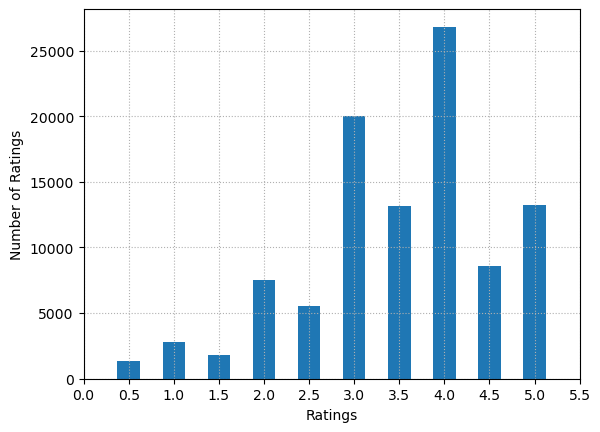

In [54]:
rates = ratings.groupby(['rating'])['rating'].count()
index = rates.index.values
height = rates.values
plt.bar(index, height, width=0.25)
plt.grid(linestyle=':')
plt.xticks(np.arange(0,6,0.5),rotation=0)
plt.ylabel('Number of Ratings')
plt.xlabel('Ratings')
plt.savefig(os.path.join(fig_path, "q1b.png"),dpi=500,bbox_inches='tight')
plt.show()

[329 317 307 ...   1   1   1]


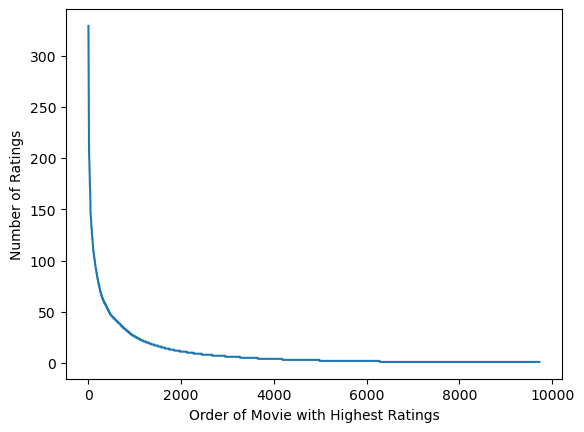

In [36]:
unique_movie,unique_counts=np.unique(ratings.movieId.values,return_counts=True)
count_sorts=np.argsort(unique_counts)
length=range(1,len(unique_movie)+1)
count=unique_counts[count_sorts[::-1]] #Decreasing Frequency
# print(count)
plt.plot(length,count)
plt.xlabel('Order of Movie with Highest Ratings')
plt.ylabel('Number of Ratings')
plt.savefig(os.path.join(fig_path, "q1c.png"))
plt.show()

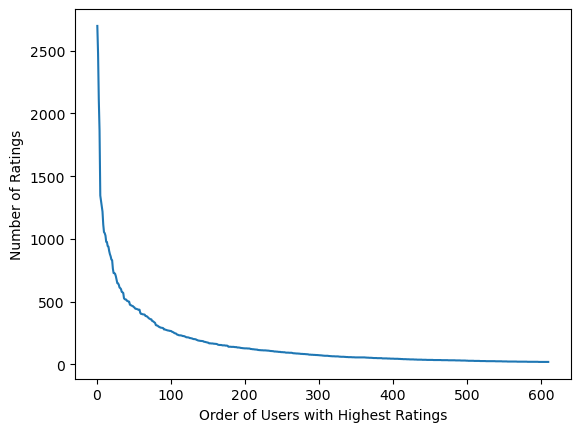

In [37]:
unique_users,unique_counts=np.unique(ratings.userId.values,return_counts=True)
count_sorts=np.argsort(unique_counts)
length=range(1,len(unique_users)+1)
count=unique_counts[count_sorts[::-1]] #Decreasing Frequency
# print(count)
plt.plot(length,count)
plt.xlabel('Order of Users with Highest Ratings')
plt.ylabel('Number of Ratings')
plt.savefig(os.path.join(fig_path, "q1d.png"))
plt.show()

In [5]:
movie_rating_vars = ratings.groupby(['movieId'])['rating'].var(ddof=0)
bins = int ( (movie_rating_vars.values.max() - movie_rating_vars.values.min() )/ 0.5 )
cuted = pd.cut(movie_rating_vars.values, bins = bins, right=True, ordered= True)

In [28]:
cuted = pd.cut(movie_rating_vars.values, bins = bins, right=True, ordered= True)

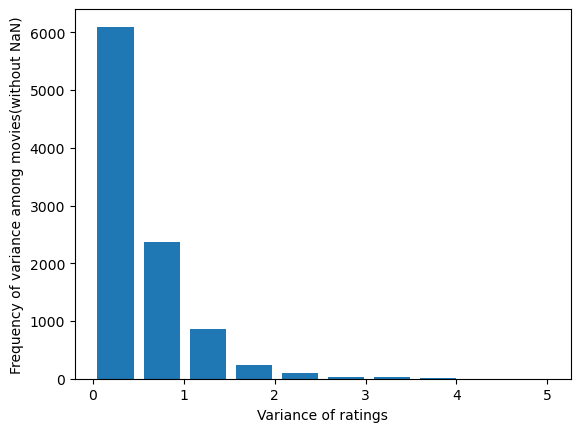

In [29]:
height = cuted.value_counts()
x_axis = []
for c in cuted.categories:
    # print(c.left)
    x_axis.append(( c.left + c.right)/2 )

plt.bar(x_axis, cuted.value_counts(), width= 0.4)
plt.ylabel("Frequency of variance among movies (without NaN)")
plt.xlabel("Variance of ratings") 
plt.savefig(os.path.join(fig_path, "q1f.png"))
plt.show()

## Question 2

1): $\mu_{u} = \frac{\sum_{k=0}^{K}r_{uk}}{|I_{u}|}$

2): $I_{u} \cap I_{v}$ means the intersection of ratings from both user $u$ and user $v$. $I_{u} \cap I_{v}$ can be empty set.

## Question 4

In [4]:
# Get lineformat corresponding tags CSV file in dataset  - Documentation - https://surprise.readthedocs.io/en/stable/reader.html
reader = Reader(rating_scale=(0.5, 5))
Dataset_Ratings = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']] ,reader=reader)


In [5]:
Ks = np.arange(2,102,2) 
rmse = []
mae = []
for k in Ks:
    knn = KNNWithMeans(k = k, sim_options={'name': 'pearson'})
    final_res = cross_validate(knn, measures = ['rmse', 'mae'], data = Dataset_Ratings, cv = 10, n_jobs= 8)
    rmse.append(np.mean(final_res['test_rmse']))
    mae.append(np.mean(final_res['test_mae']))

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity 

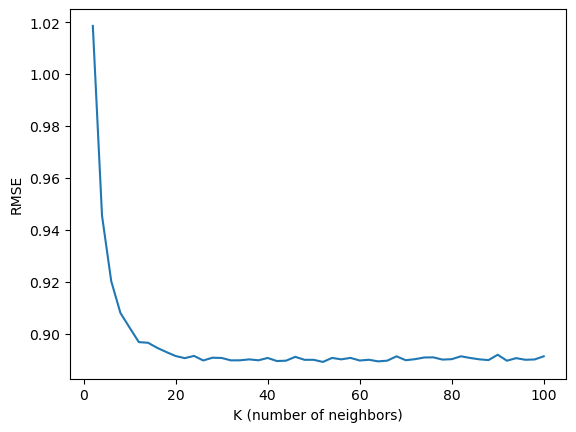

In [8]:
plt.plot(Ks, rmse)
plt.xlabel("K (number of neighbors)")
plt.ylabel("RMSE")
plt.savefig(os.path.join(fig_path, "q4_ks_rmse.png"))
plt.show()

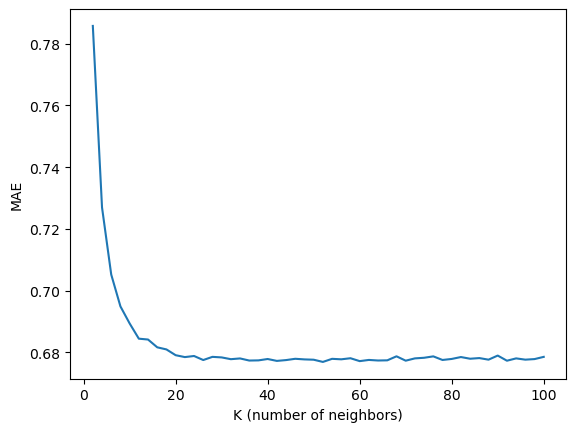

In [9]:
plt.plot(Ks, mae)
plt.xlabel("K (number of neighbors)")
plt.ylabel("MAE")
plt.savefig(os.path.join(fig_path, "q4_ks_mae.png"))
plt.show()

In [17]:
deta = 0.0001
for i, rmse_ in enumerate(rmse):
    if i == len(rmse) -1:
        break
    else:
        error = rmse_ - rmse[i+1] 
        # print(error)
        if  error < deta:
            print("current index of rmse(s):", i)
            print("current k: ", Ks[i])

current index of rmse(s): 10
current k:  22
current index of rmse(s): 12
current k:  26
current index of rmse(s): 13
current k:  28
current index of rmse(s): 15
current k:  32
current index of rmse(s): 16
current k:  34
current index of rmse(s): 18
current k:  38
current index of rmse(s): 20
current k:  42
current index of rmse(s): 21
current k:  44
current index of rmse(s): 23
current k:  48
current index of rmse(s): 25
current k:  52
current index of rmse(s): 27
current k:  56
current index of rmse(s): 29
current k:  60
current index of rmse(s): 31
current k:  64
current index of rmse(s): 32
current k:  66
current index of rmse(s): 34
current k:  70
current index of rmse(s): 35
current k:  72
current index of rmse(s): 36
current k:  74
current index of rmse(s): 38
current k:  78
current index of rmse(s): 39
current k:  80
current index of rmse(s): 43
current k:  88
current index of rmse(s): 45
current k:  92
current index of rmse(s): 47
current k:  96
current index of rmse(s): 48
cur

In [18]:
deta = 0.0001
for i, mae_ in enumerate(mae):
    if i == len(mae) -1:
        break
    else:
        error = mae_ - mae[i+1] 
        # print(error)
        if  error < deta:
            print("current index of mae(s):", i)
            print("current k: ", Ks[i])

current index of mae(s): 10
current k:  22
current index of mae(s): 12
current k:  26
current index of mae(s): 15
current k:  32
current index of mae(s): 17
current k:  36
current index of mae(s): 18
current k:  38
current index of mae(s): 20
current k:  42
current index of mae(s): 21
current k:  44
current index of mae(s): 25
current k:  52
current index of mae(s): 27
current k:  56
current index of mae(s): 29
current k:  60
current index of mae(s): 31
current k:  64
current index of mae(s): 32
current k:  66
current index of mae(s): 34
current k:  70
current index of mae(s): 35
current k:  72
current index of mae(s): 36
current k:  74
current index of mae(s): 38
current k:  78
current index of mae(s): 39
current k:  80
current index of mae(s): 41
current k:  84
current index of mae(s): 43
current k:  88
current index of mae(s): 45
current k:  92
current index of mae(s): 47
current k:  96
current index of mae(s): 48
current k:  98


In [19]:
print("steady state of RMSE (k = 26): ", rmse[12])
print("steady state of MAE (k = 26): ", mae[12])

steady state of RMSE (k = 26):  0.8896696981676074
steady state of MAE (k = 26):  0.6774666577459358


## Question 6

In [36]:
def plot_k_rmse_for_trimmed_data(ks, rmse_, trimmed_name):
    
    plt.plot(ks,rmse_,color='g')
    plt.grid(linestyle=':')
    plt.title('%s movie trimming- Average RMSE :' % (trimmed_name))
    plt.ylabel('Average RMSE')
    plt.xlabel('Number of neighbours')
    plt.savefig( os.path.join(fig_path, trimmed_name + "_trimming_rmse_.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_threshold_roc_curve(y_true,  res, trimmed_name, K):
    thres_list = [2.5, 3, 3.5, 4]
    
    for thres in thres_list:
        binary_y_trues = []
        for row in y_true:
            if row> thres:
                binary_y_trues.append(1)
            else:
                binary_y_trues.append(0)
        y_pred =  [row.est for row in res]
        fpr, tpr, _ = roc_curve(binary_y_trues, y_pred)
        
        auc_score = roc_auc_score(binary_y_trues, y_pred)
        
        plt.gcf().clear()
        plt.figure(figsize=(10,8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f' %(thres,auc_score), linewidth=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        title = trimmed_name + " trmming"
        plt.title('ROC Curves for {}'.format(title), fontweight="bold")
        plt.savefig(os.path.join(fig_path, title + "_threshold_" + str(thres)+ "_.png"))
        plt.show() 


popular trimming of current index of rmse(s): 33
popular trmming of current k:  68


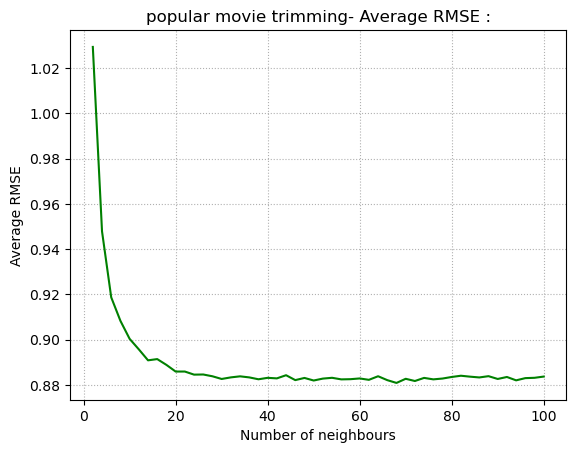

unpopular trimming of current index of rmse(s): 31
unpopular trmming of current k:  64


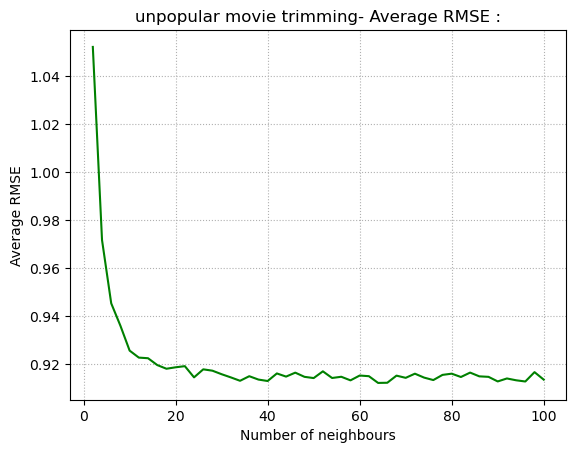

high variance trimming of current index of rmse(s): 2
high variance trmming of current k:  6


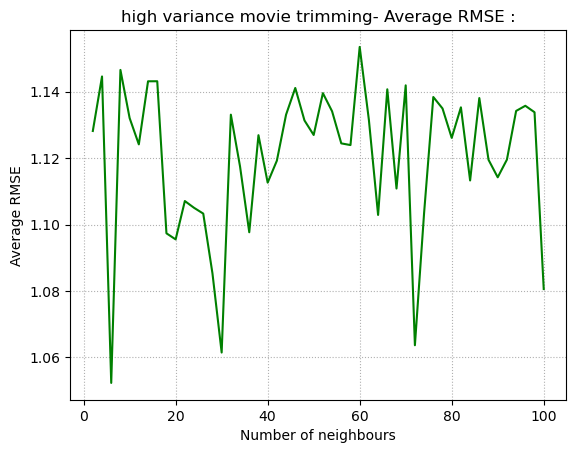

In [15]:
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)

for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)
    trimmed_rmse = []
    ks = np.arange(2, 102, 2)

    for k in ks:
        temp_rmse = []
        knn = KNNWithMeans(k = k, sim_options={'name': 'pearson'}, verbose= False )
        for training, validation in kf.split(trimmed_dataset):
            
            res = knn.fit(trainset=training).test(validation)
            temp_rmse.append(accuracy.rmse(res, verbose= False))
        # mean_rmse = np.mean(temp_rmse)
        trimmed_rmse.append(np.mean(temp_rmse))
    # deta = 0.00001 
    index_ = trimmed_rmse.index(np.min(trimmed_rmse))
    print(name + " trimming of current index of rmse(s):", index_ )
    print(name + " trmming of current k: ", ks[index_])
    plot_k_rmse_for_trimmed_data(ks, trimmed_rmse, name)


<Figure size 640x480 with 0 Axes>

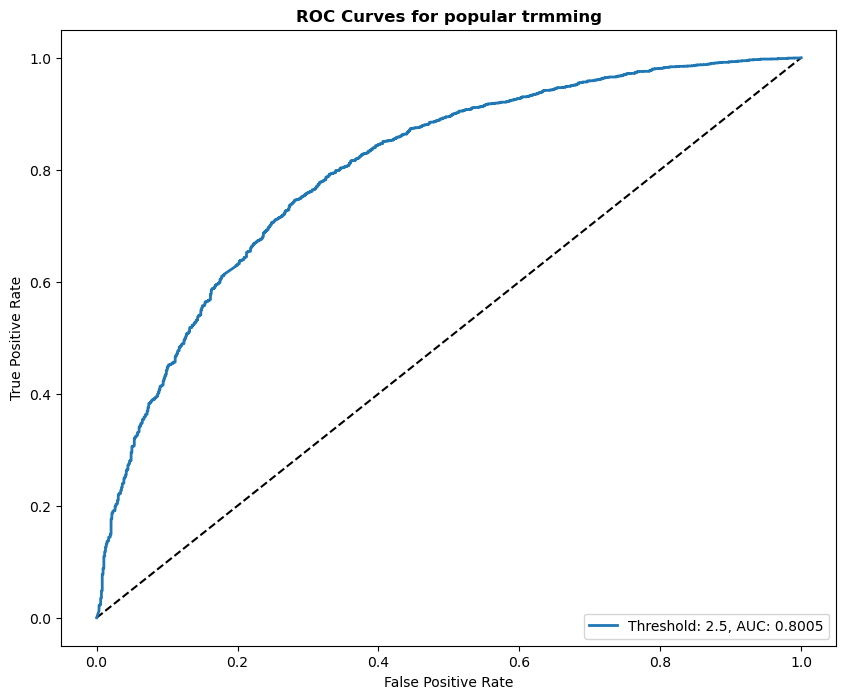

<Figure size 640x480 with 0 Axes>

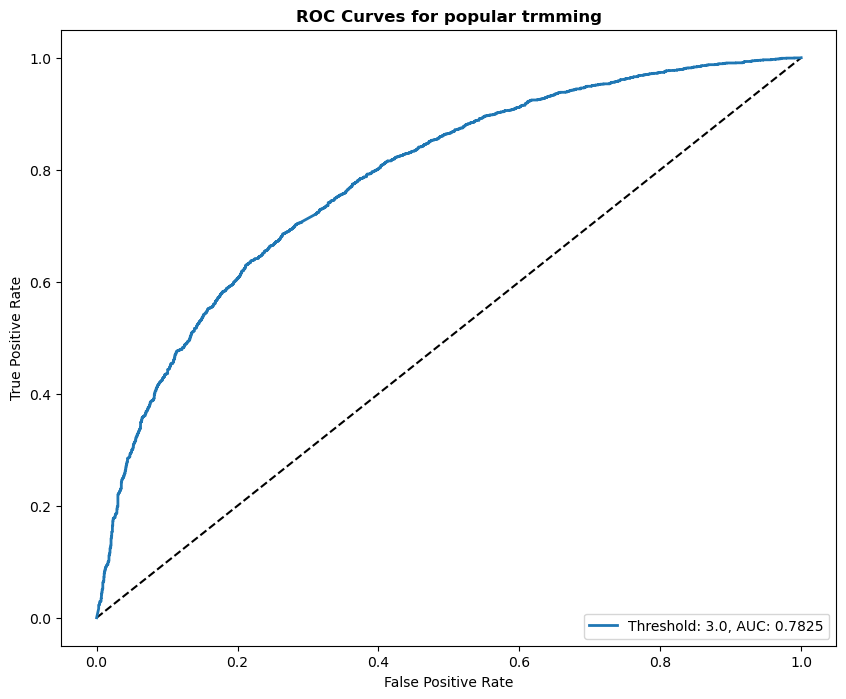

<Figure size 640x480 with 0 Axes>

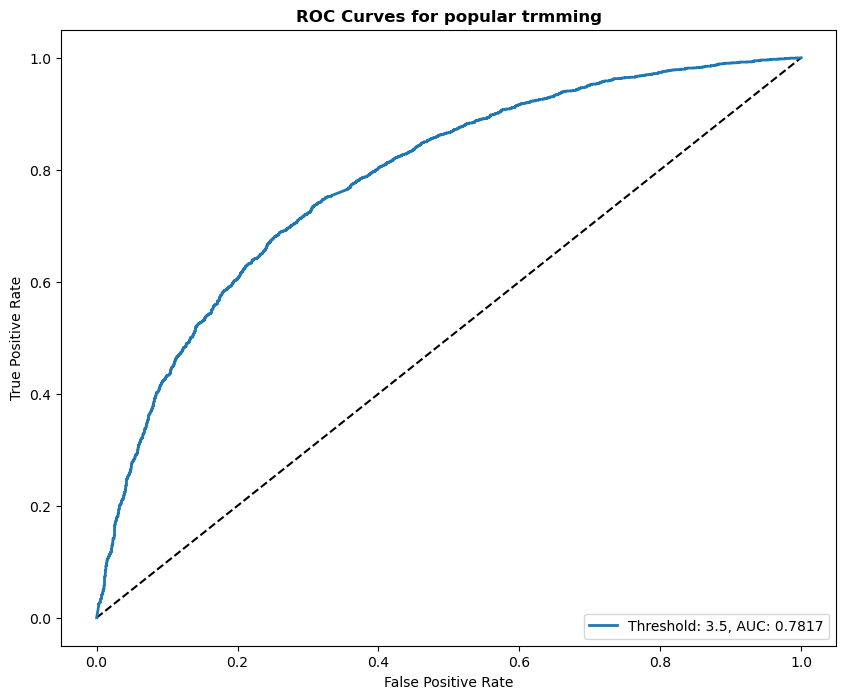

<Figure size 640x480 with 0 Axes>

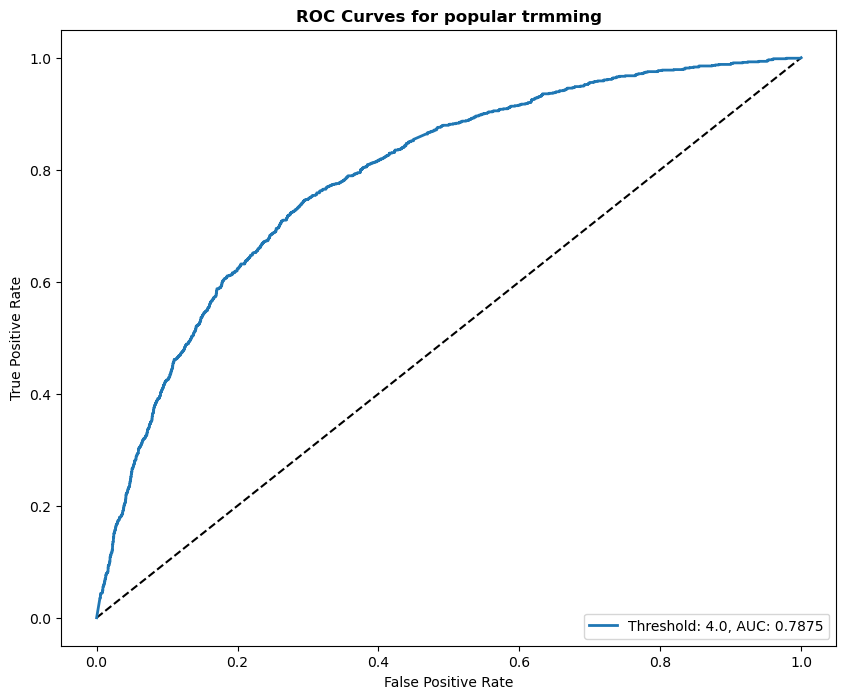

<Figure size 640x480 with 0 Axes>

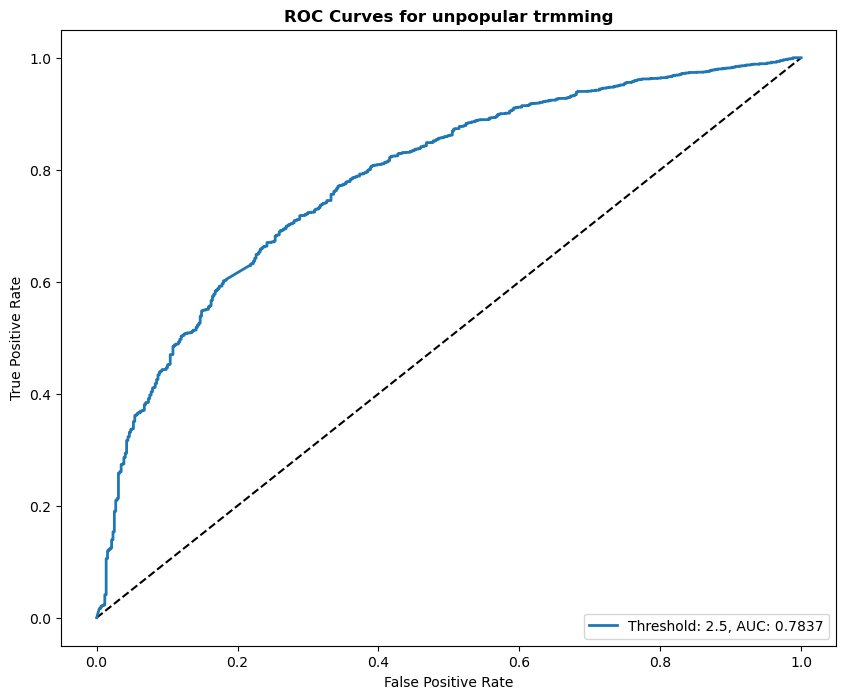

<Figure size 640x480 with 0 Axes>

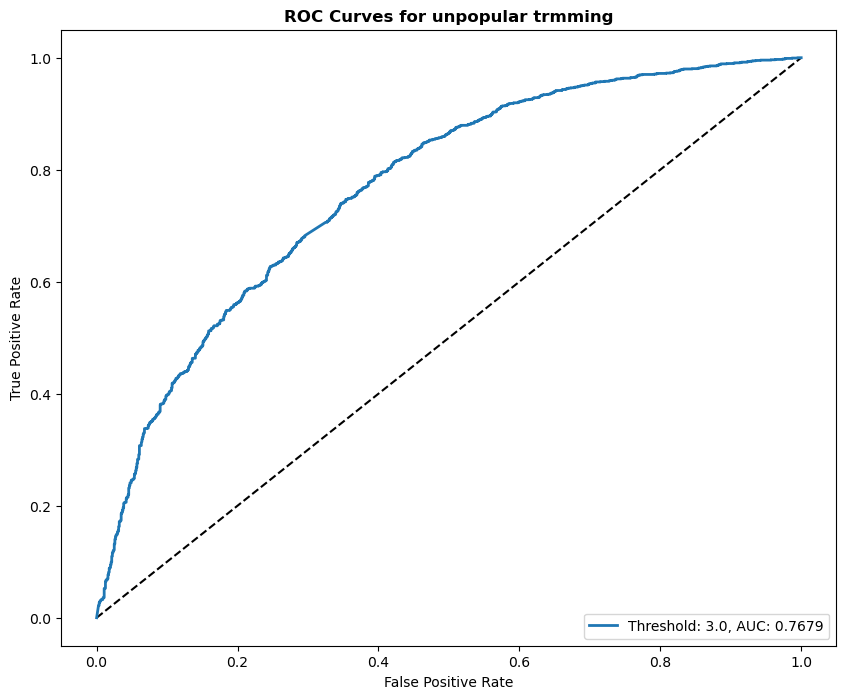

<Figure size 640x480 with 0 Axes>

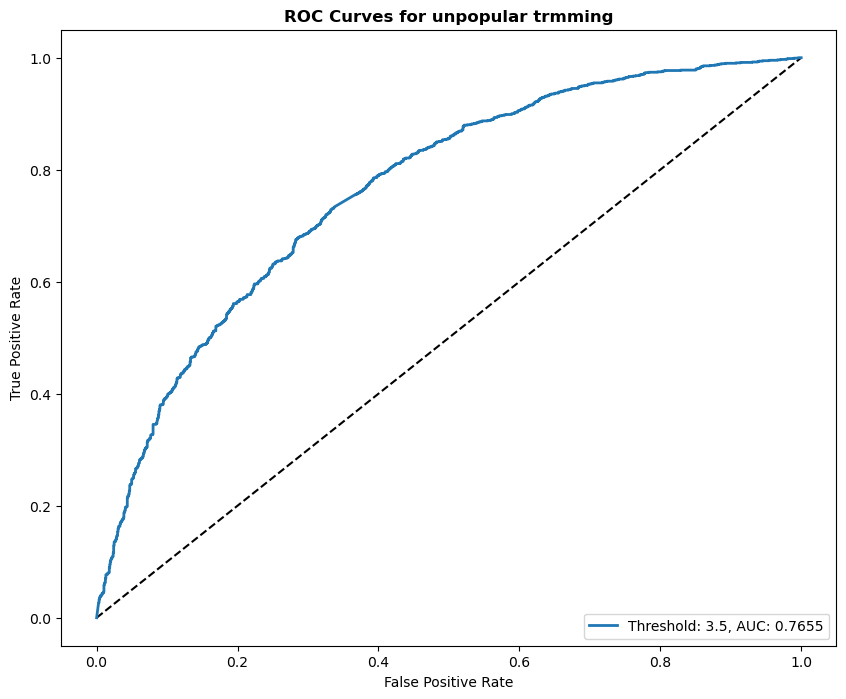

<Figure size 640x480 with 0 Axes>

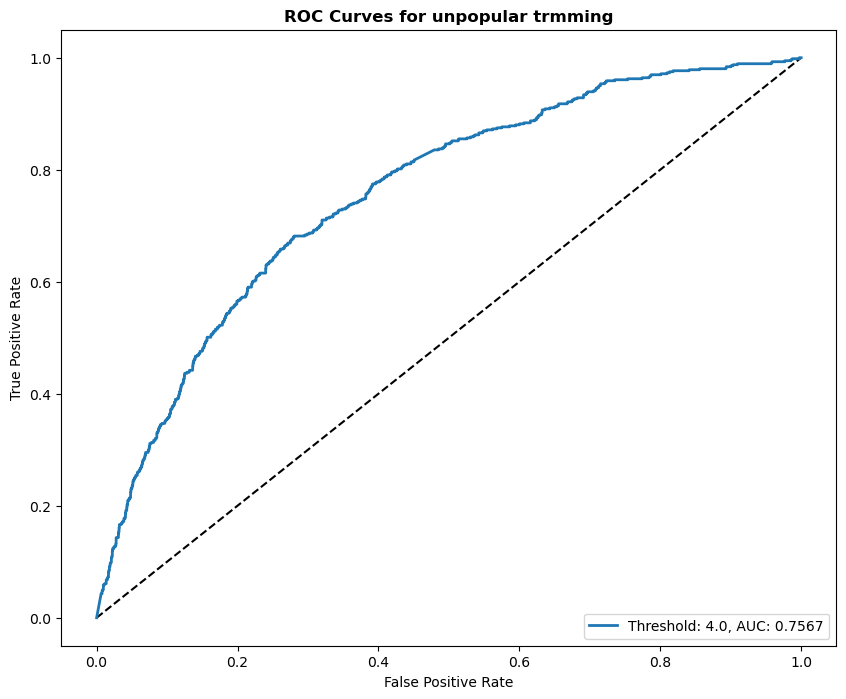

<Figure size 640x480 with 0 Axes>

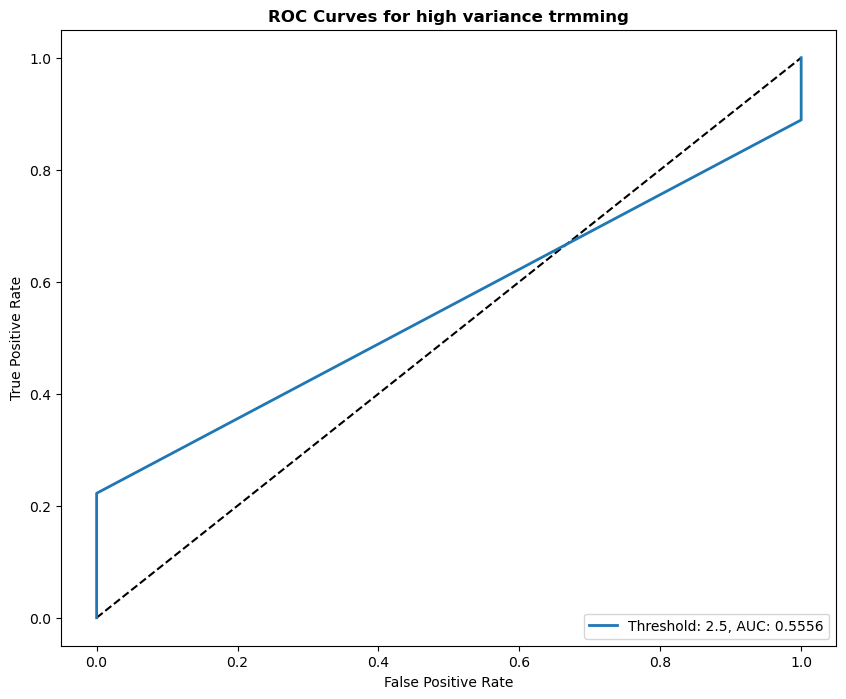

<Figure size 640x480 with 0 Axes>

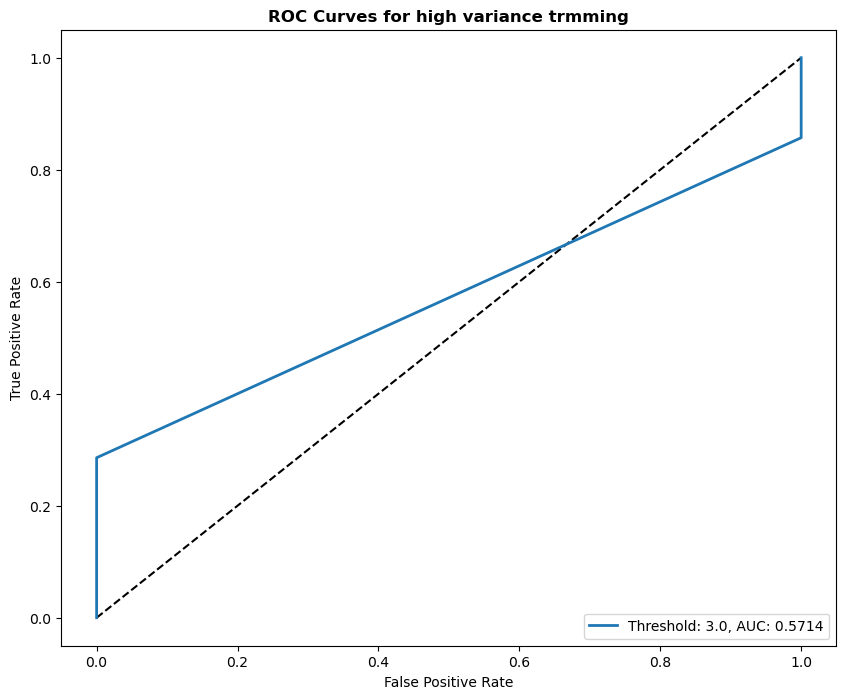

<Figure size 640x480 with 0 Axes>

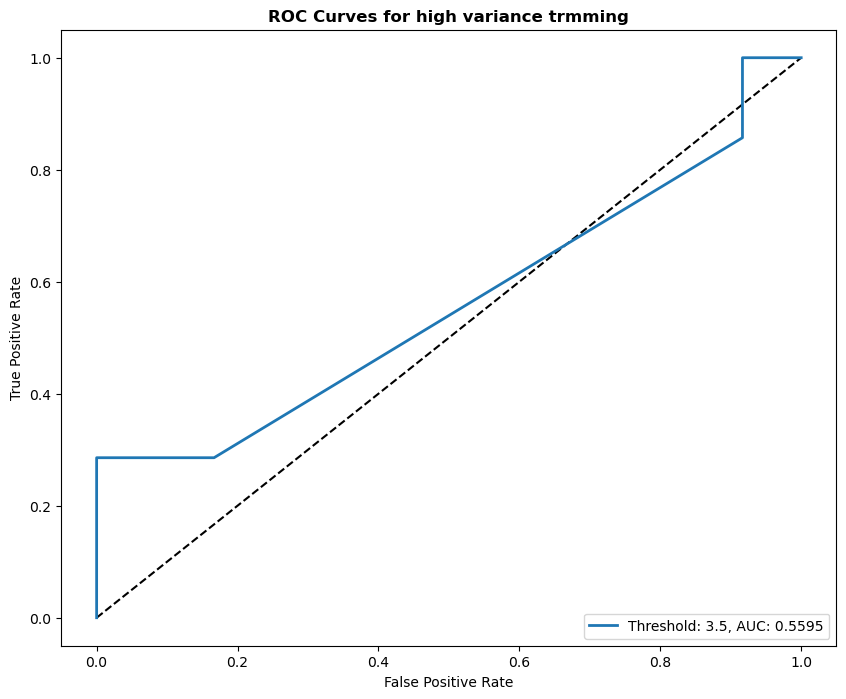

<Figure size 640x480 with 0 Axes>

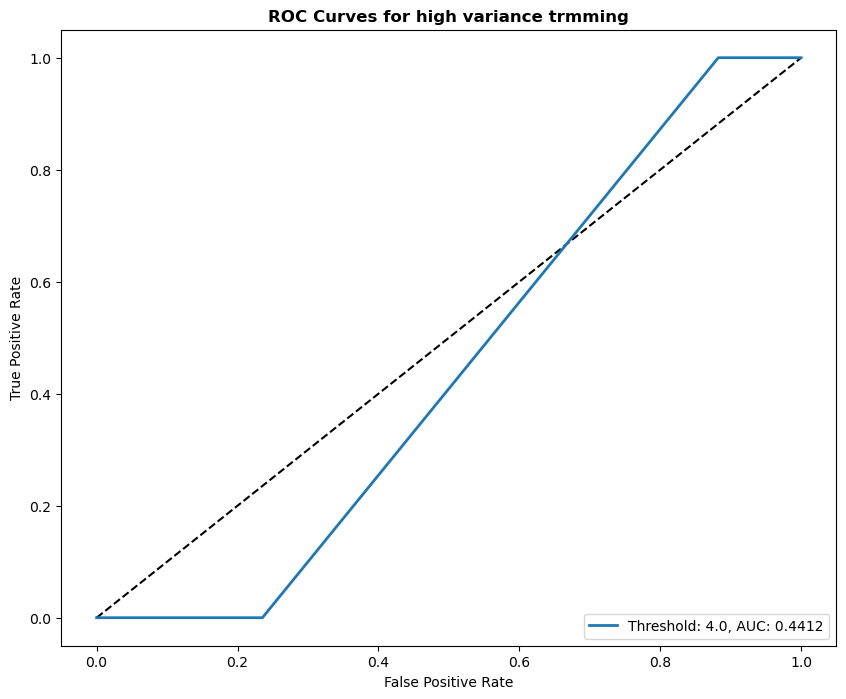

<Figure size 640x480 with 0 Axes>

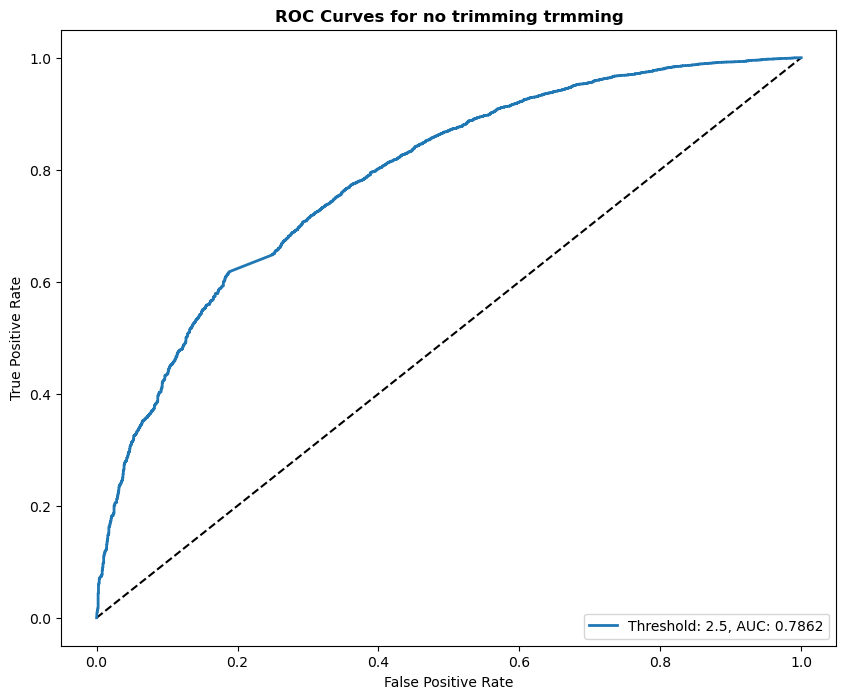

<Figure size 640x480 with 0 Axes>

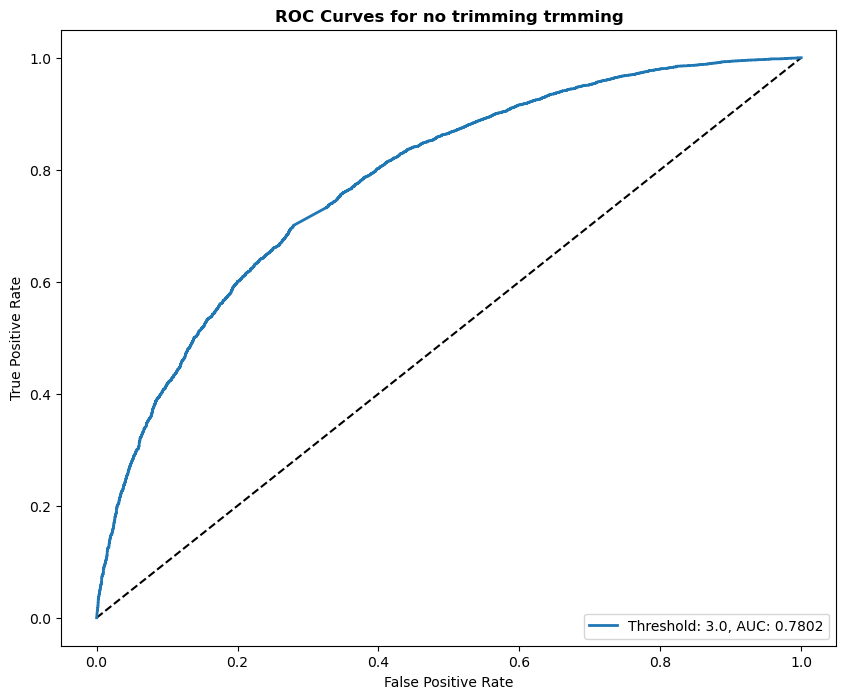

<Figure size 640x480 with 0 Axes>

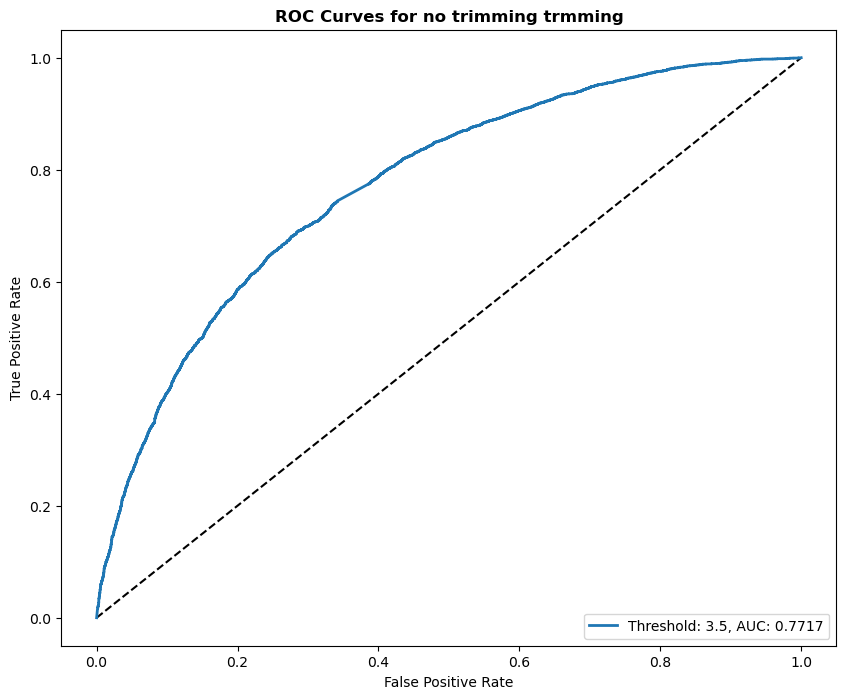

<Figure size 640x480 with 0 Axes>

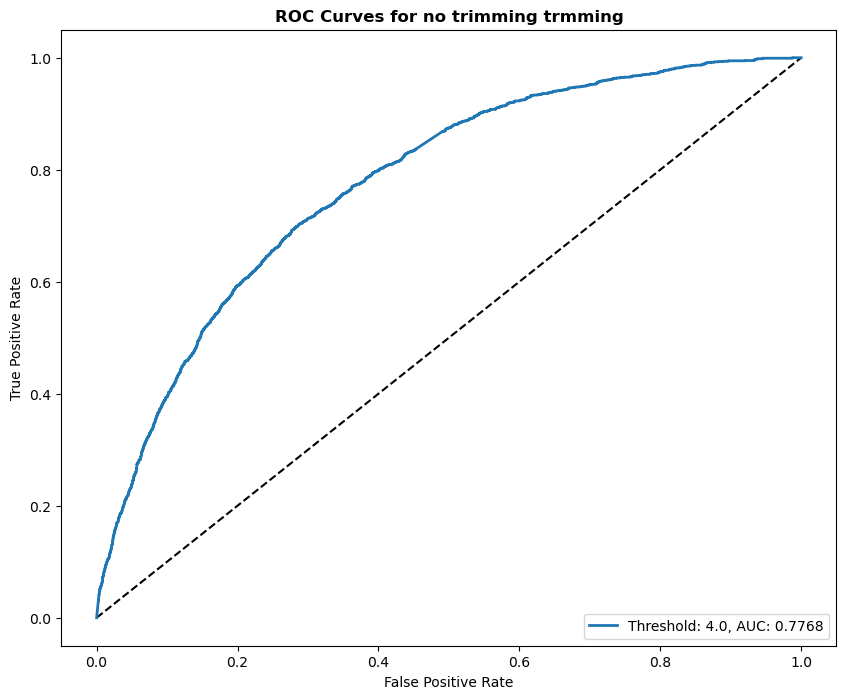

In [22]:
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 
trimmed_ratings_with_name.append( ('no trimming',  ratings ) )

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)

for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)

    k = 64
    knn = KNNWithMeans(k = k, sim_options={'name': 'pearson'}, verbose= False )
    training, validation = train_test_split(trimmed_dataset, test_size= 0.1)
            
    res = knn.fit(trainset=training).test(validation)
    y_true = [val[2] for val in  validation]
    plot_threshold_roc_curve(y_true, res, trimmed_name= name, K= k)
    
        
        # temp_rmse.append(accuracy.rmse(res, verbose= False))
        


## Question8 (A)

In [8]:
rmse = []
mae = []
cv = 10
Ks = np.arange(2,52,2)
for k in Ks:
    print('K is', k)
    nmf = NMF(n_factors = k)
    final_res = cross_validate(nmf, data = Dataset_Ratings, measures=['rmse', 'mae'], cv=cv)
    rmse.append(np.mean(final_res["test_rmse"]))
    mae.append(np.mean(final_res["test_mae"]))

K is 2
K is 4
K is 6
K is 8
K is 10
K is 12
K is 14
K is 16
K is 18
K is 20
K is 22
K is 24
K is 26
K is 28
K is 30
K is 32
K is 34
K is 36
K is 38
K is 40
K is 42
K is 44
K is 46
K is 48
K is 50


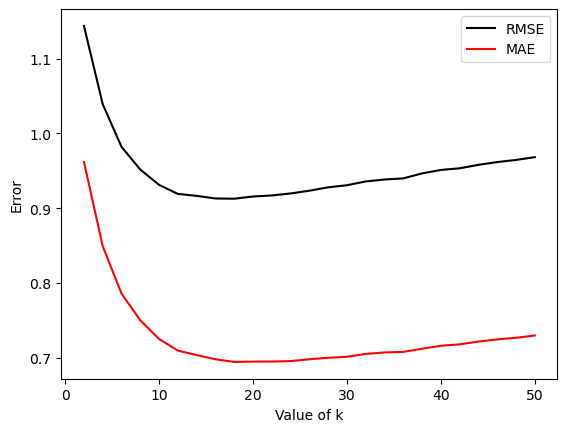

<Figure size 640x480 with 0 Axes>

In [9]:
fig = plt.figure()
plt.plot(Ks,rmse,color = 'black',label = 'RMSE')
plt.plot(Ks,mae,color = 'red', label = 'MAE')
plt.xlabel('Value of k')
plt.ylabel("Error")
plt.legend()
plt.show()
plt.savefig(os.path.join(fig_path, "q8A_ks_rmse_mae.png"))

## Question8(B)

In [11]:
idx_latent_fac_RMSE = np.argmin(rmse)
idx_latent_fac_MAE = np.argmin(mae)
latent_fac_RMSE = Ks[idx_latent_fac_RMSE]
latent_fac_MAE = Ks[idx_latent_fac_MAE]
min_avg_RMSE = min(rmse)
min_avg_MAE = min(mae)
print("RMSE: Optimal number of latent factors is {}, min avg RMSE is {}".format(latent_fac_RMSE, min_avg_RMSE))
print("MAE: Optimal number of latent factors is {}, min avg mae is {}".format(latent_fac_MAE, min_avg_MAE))


RMSE: Optimal number of latent factors is 16, min avg RMSE is 0.9122813703074181
MAE: Optimal number of latent factors is 20, min avg mae is 0.6937629934670132


In [25]:
num_movies = len(movies)
all_genres = []
for i in range(num_movies):
    gen = movies.iloc[i]['genres'].lower()
    gen = gen.split('|')
    for j in range(len(gen)):
        if gen[j] not in all_genres:
            all_genres.append(gen[j])
print(all_genres)
print(len(all_genres) - 1) # subtract 1 because of the (no genres listed)

['adventure', 'animation', 'children', 'comedy', 'fantasy', 'romance', 'drama', 'action', 'crime', 'thriller', 'horror', 'mystery', 'sci-fi', 'war', 'musical', 'documentary', 'imax', 'western', 'film-noir', '(no genres listed)']
19


## Question8(C)

In [28]:
def plot_k_rmse_for_nmf(ks, rmse_, trimmed_name):
    
    plt.plot(ks,rmse_,color='g')
    plt.grid(linestyle=':')
    plt.title('%s movie nmf- Average RMSE :' % (trimmed_name))
    plt.ylabel('Average RMSE')
    plt.xlabel('Value of K')
    plt.savefig( os.path.join(fig_path, trimmed_name + "_nmf_rmse.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


popular Optimal latent factor: 18
popular Min average RMSE 0.9048297115551025


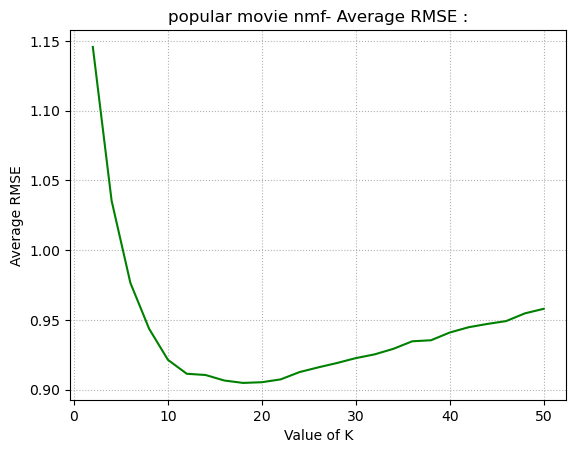

unpopular Optimal latent factor: 20
unpopular Min average RMSE 0.9336564744456458


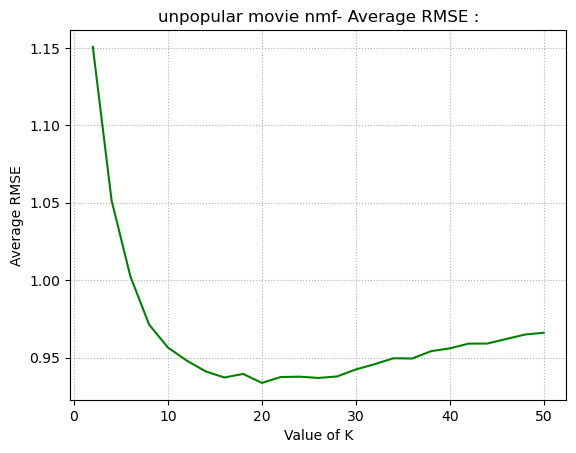

high variance Optimal latent factor: 32
high variance Min average RMSE 1.0661686621867708


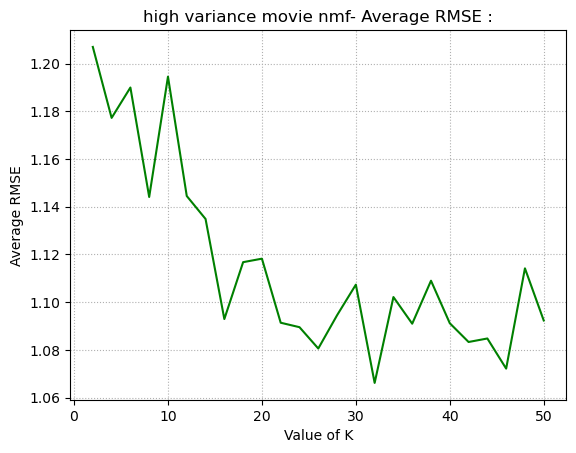

In [34]:
Ks = np.arange(2,52,2)
cv = 10
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)

for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)
    trimmed_rmse_nmf = []

    for k in Ks:
        temp_rmse_nmf = []
        nmf = NMF(n_factors = k)
        for training, validation in kf.split(trimmed_dataset):
            res = nmf.fit(trainset=training).test(validation)
            temp_rmse_nmf.append(accuracy.rmse(res, verbose= False))
        trimmed_rmse_nmf.append(np.mean(temp_rmse_nmf))
    idx = np.argmin(trimmed_rmse_nmf)
    optim_fac = Ks[idx]
    min_RMSE = min(trimmed_rmse_nmf)
    print(name + " Optimal latent factor:", optim_fac )
    print(name + " Min average RMSE", min_RMSE)
    plot_k_rmse_for_nmf(Ks, trimmed_rmse_nmf, name)

In [37]:
def plot_threshold_roc_curve_nmf(y_true,  res, trimmed_name, K):
    thres_list = [2.5, 3, 3.5, 4]
    
    for thres in thres_list:
        binary_y_trues = []
        for row in y_true:
            if row> thres:
                binary_y_trues.append(1)
            else:
                binary_y_trues.append(0)
        y_pred =  [row.est for row in res]
        fpr, tpr, _ = roc_curve(binary_y_trues, y_pred)
        
        auc_score = roc_auc_score(binary_y_trues, y_pred)
        
        plt.gcf().clear()
        plt.figure(figsize=(10,8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f' %(thres,auc_score), linewidth=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        title = trimmed_name + " nmf"
        plt.title('ROC Curves for {}'.format(title), fontweight="bold")
        plt.savefig(os.path.join(fig_path, title + "_threshold_" + str(thres)+ "_.png"))
        plt.show() 

<Figure size 640x480 with 0 Axes>

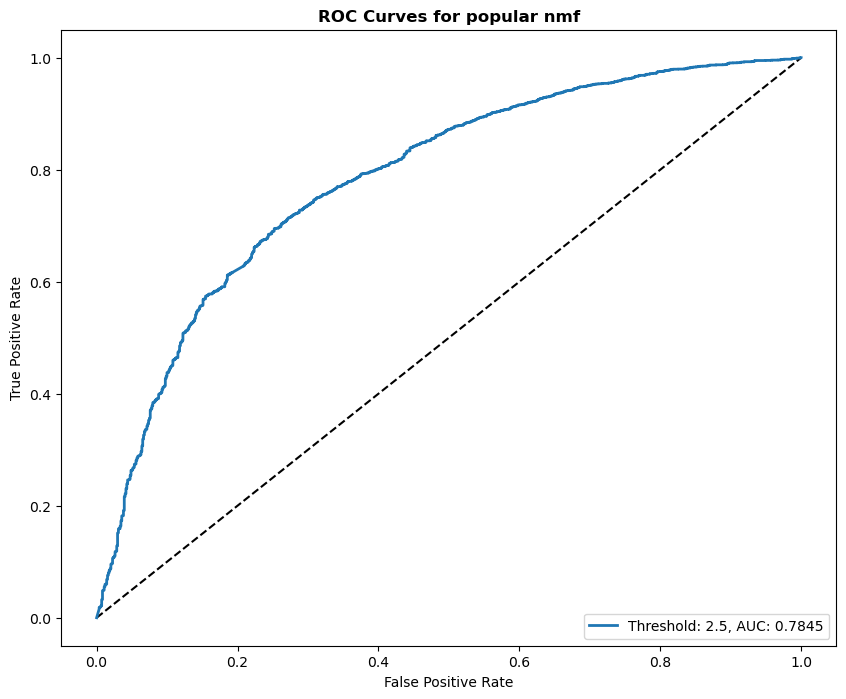

<Figure size 640x480 with 0 Axes>

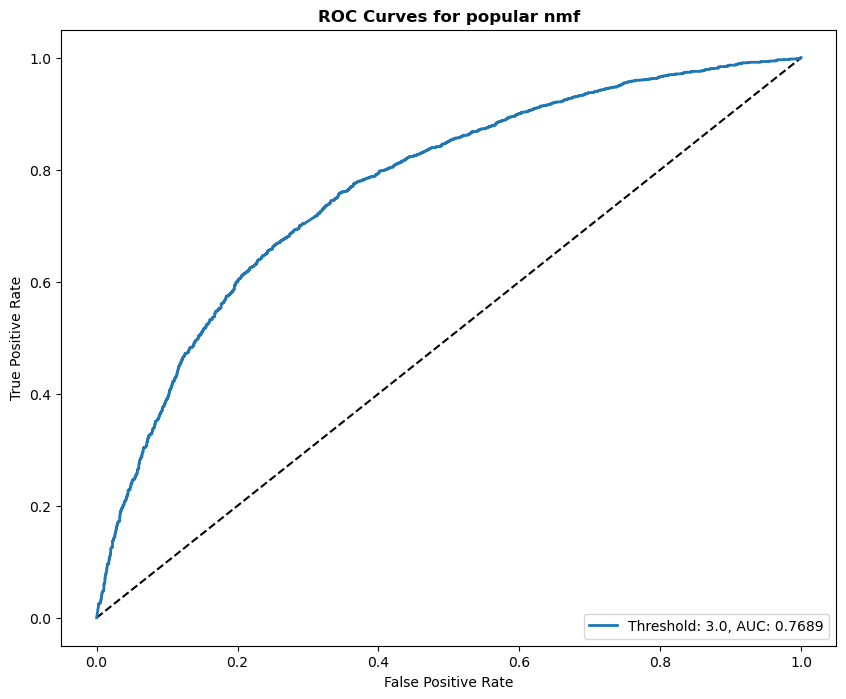

<Figure size 640x480 with 0 Axes>

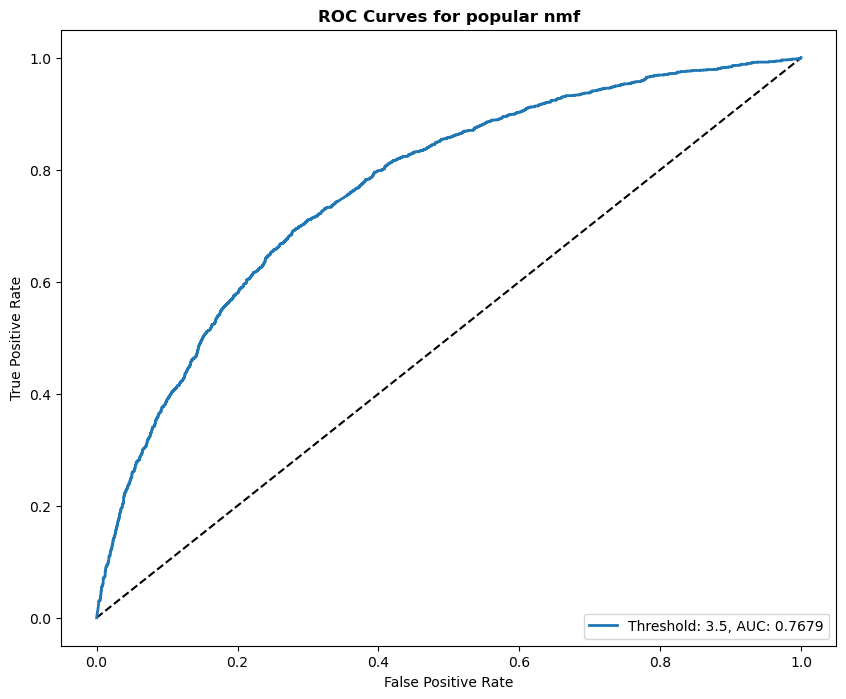

<Figure size 640x480 with 0 Axes>

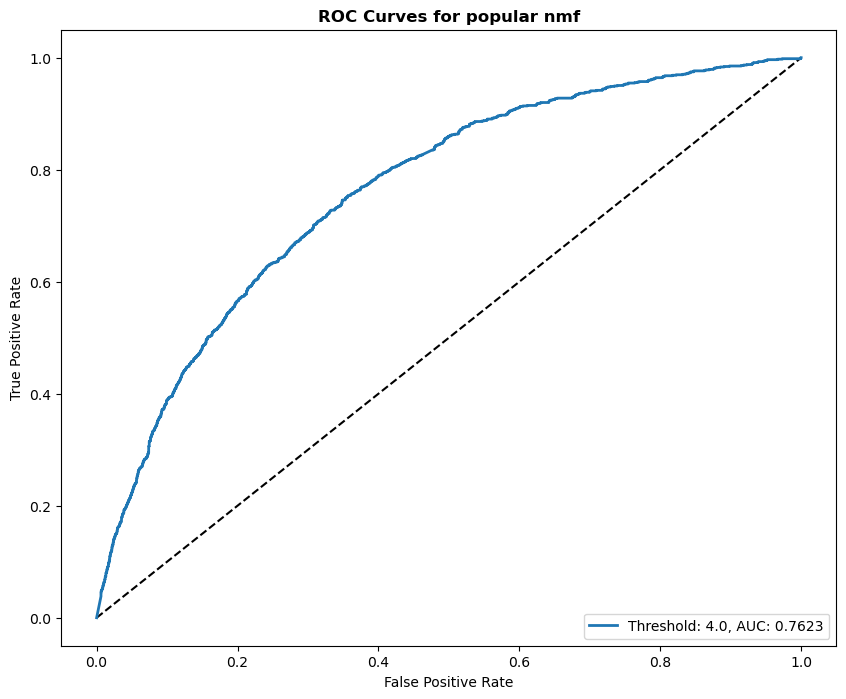

<Figure size 640x480 with 0 Axes>

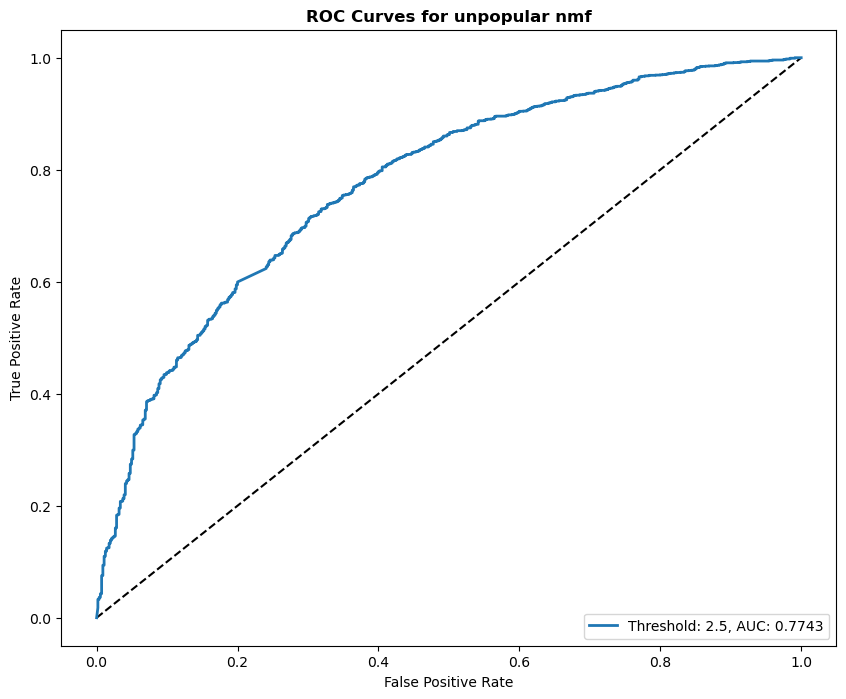

<Figure size 640x480 with 0 Axes>

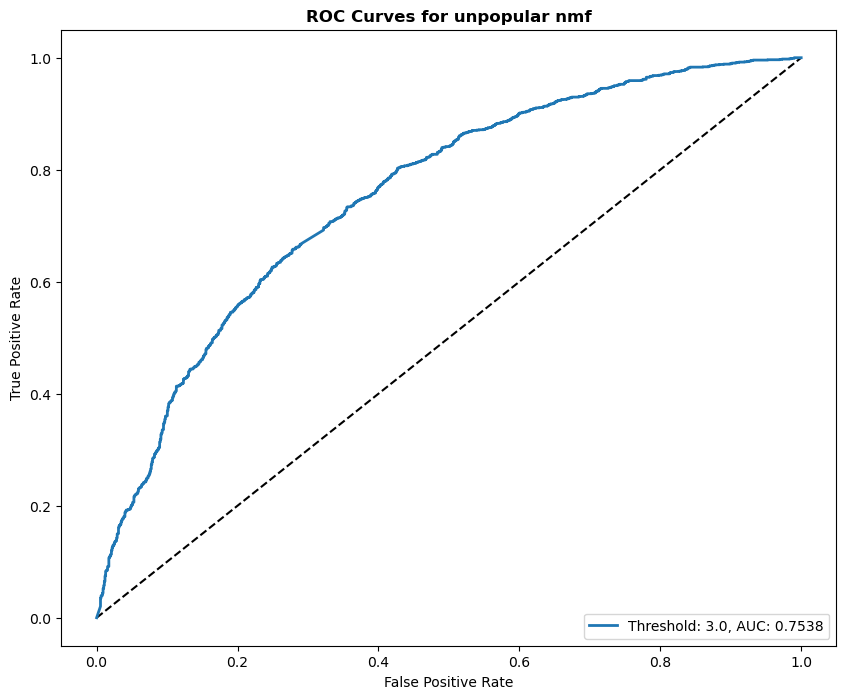

<Figure size 640x480 with 0 Axes>

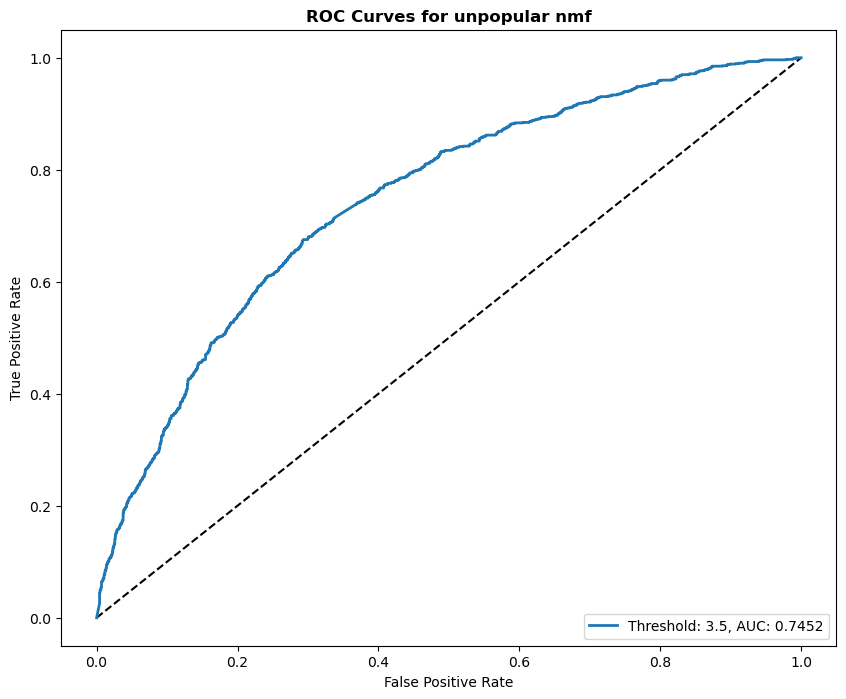

<Figure size 640x480 with 0 Axes>

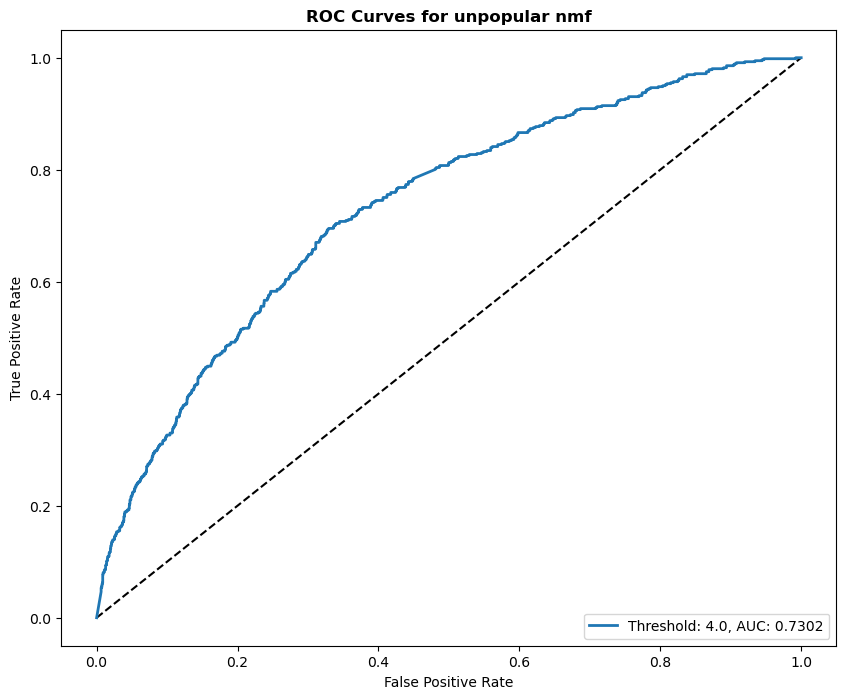

<Figure size 640x480 with 0 Axes>

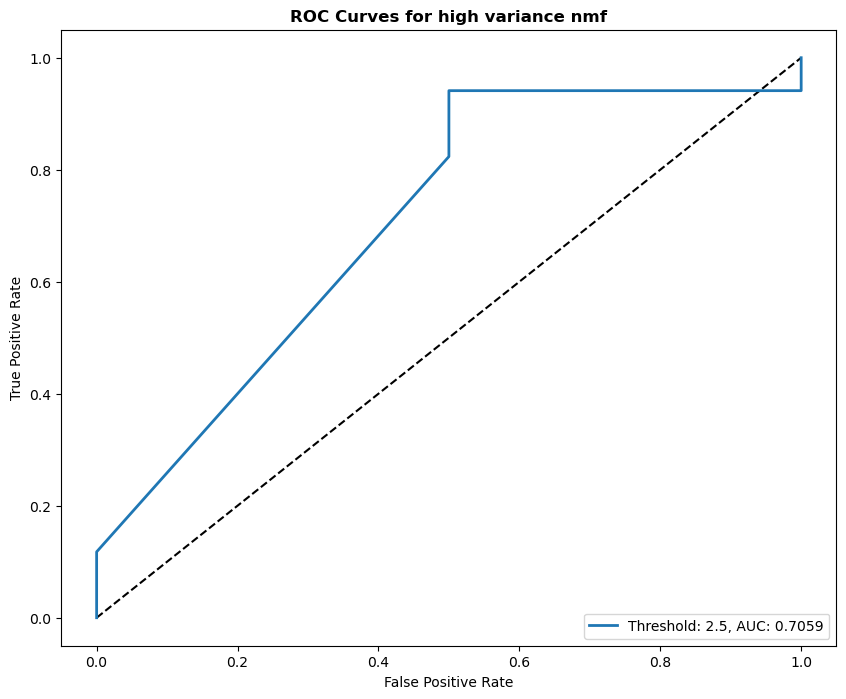

<Figure size 640x480 with 0 Axes>

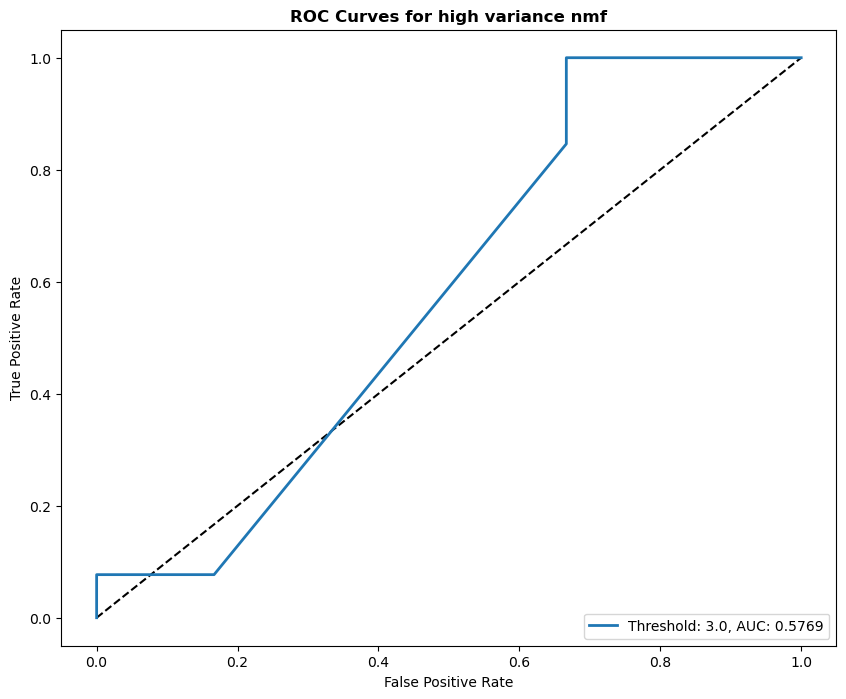

<Figure size 640x480 with 0 Axes>

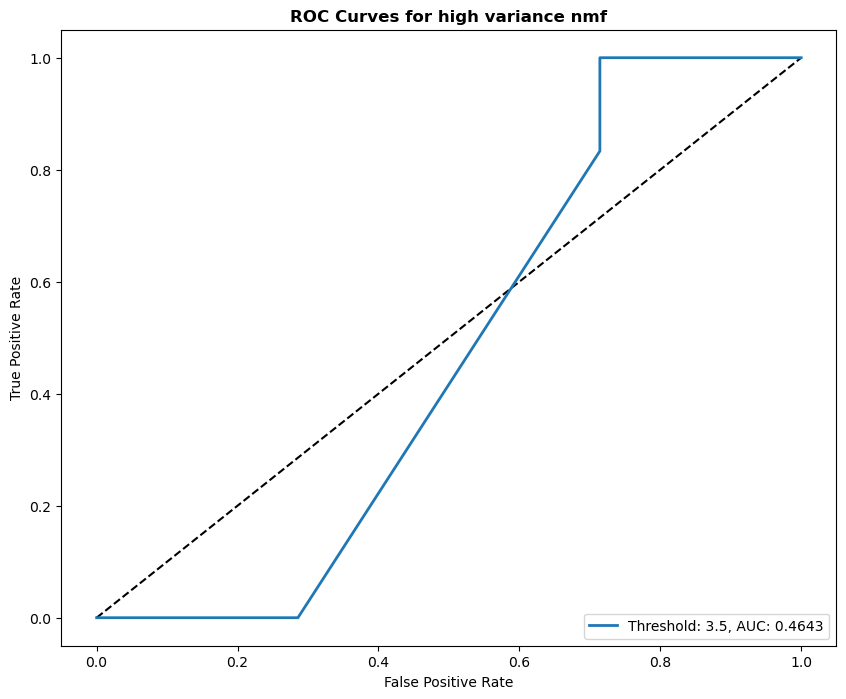

<Figure size 640x480 with 0 Axes>

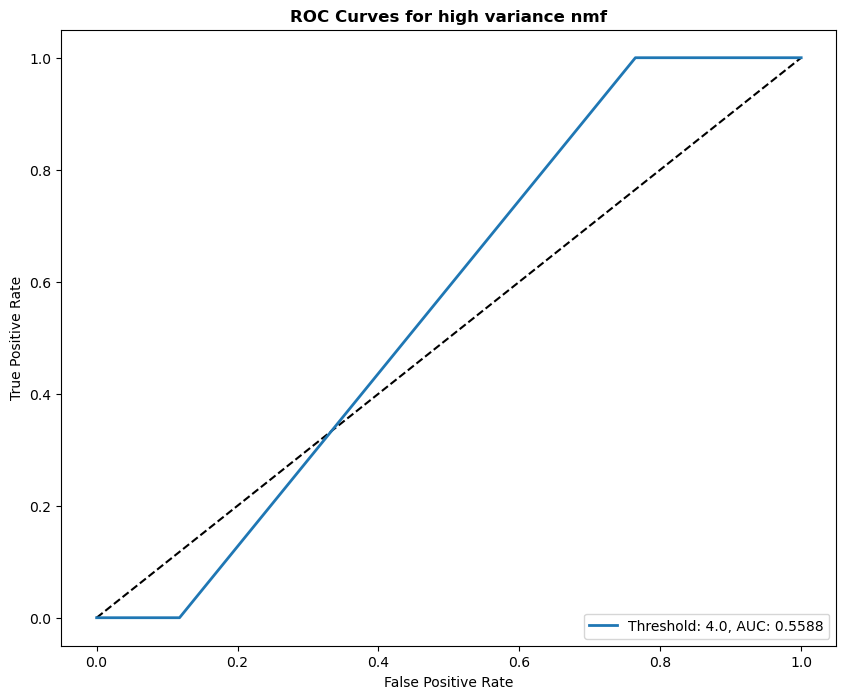

In [39]:
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 

opt_n = {'popular':18, 'unpopular':20, 'high variance':32}

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)
for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)

    k = opt_n[name]
    nmf_opt = NMF(n_factors = k)
    training, validation = train_test_split(trimmed_dataset, test_size= 0.1)
            
    res = nmf_opt.fit(trainset=training).test(validation)
    y_true = [val[2] for val in  validation]
    plot_threshold_roc_curve_nmf(y_true, res, trimmed_name= name, K= k)

## Question9

In [41]:
reader = Reader(rating_scale=(0.5, 5))
Dataset_Ratings = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']] ,reader=reader)
trainset, testset = train_test_split(Dataset_Ratings, test_size = 0.1)
k = 20
nmf_20 = NMF(n_factors=k)
nmf_20.fit(trainset).test(testset)
U = nmf_20.pu
V = nmf_20.qi

In [54]:
top_movie = 10
for c in range(k):
    print('The latent factor is', c)
    idx = np.argsort(V[:, c])[::-1][0:top_movie]
    score = V[idx, c]
    for i in range(top_movie):
        genres = movies.iloc[idx[i]]['genres']
        print(score[i], genres)
    print( )

The latent factor is 0
2.033229654196987 Comedy
1.946449769455096 Action|Adventure|Animation|Children|Comedy
1.86381388734614 Comedy
1.7777123235785544 Comedy|Drama|Romance
1.7331901994987011 Action
1.666873086736365 Crime|Drama|Thriller
1.6321963058362123 Action|Drama|Thriller
1.5895546812492236 Drama|Romance
1.553921530979656 Comedy|Romance
1.53282559086231 Drama|Thriller

The latent factor is 1
1.9600376192836109 Comedy|Drama
1.8465144754945138 Comedy|Crime|Mystery
1.6776334806037536 Action|Adventure|Crime|Thriller
1.62396738610607 Children|Comedy
1.5844472483592789 Drama|Fantasy
1.5532951711855219 Drama|War
1.532810577265216 Drama|War
1.5318662292698428 Children|Comedy
1.4938671301752027 Comedy|Crime
1.4452014541294966 Crime|Film-Noir

The latent factor is 2
2.432852761813595 Children|Comedy
2.388167540768046 Action|Sci-Fi
2.173127265927723 Action|Children|Comedy
2.144476535605876 Comedy|Drama|Romance
2.0588649301041633 Drama
1.849236088044628 Comedy|Musical|Romance
1.7854822036604

## Question10(A)

In [19]:
rmse_mf = []
mae_mf = []
Ks = np.arange(2,52,2)

for k in Ks:
  mf = SVD(n_factors = k)
  crs_val = cross_validate(mf,Dataset_Ratings,cv=10)
  rmse_mf.append(np.mean(crs_val['test_rmse']))
  mae_mf.append(np.mean(crs_val['test_mae']))


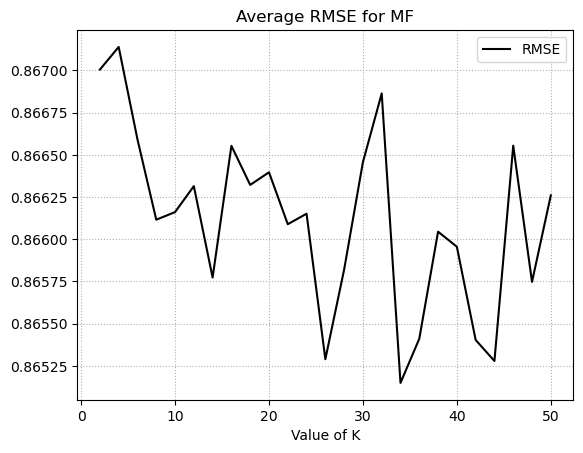

In [30]:
plt.plot(Ks,rmse_mf,color='black',label = 'RMSE')
plt.grid(linestyle=':')
plt.legend()
plt.title('Average RMSE for MF')
plt.xlabel('Value of K')
plt.savefig(os.path.join(fig_path, "q10A_ks_rmse.png"))
plt.show()

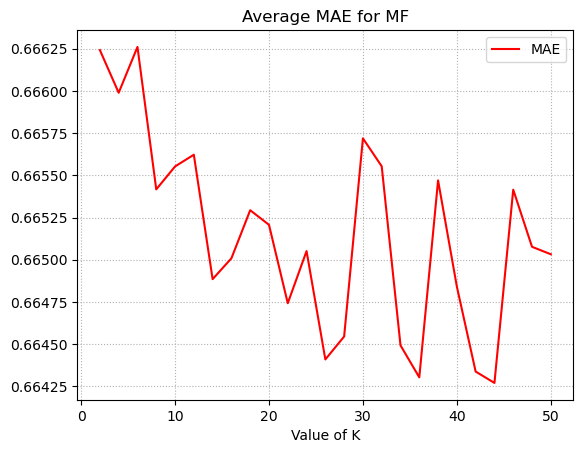

In [29]:
plt.plot(Ks,mae_mf,color='red',label = 'MAE')
plt.grid(linestyle=':')
plt.legend()
plt.title('Average MAE for MF')
plt.xlabel('Value of K')
plt.savefig(os.path.join(fig_path, "q10A_ks_mae.png"))
plt.show()

## Question10(B)

In [32]:
idx_latent_fac_RMSE_mf = np.argmin(rmse_mf)
idx_latent_fac_MAE_mf = np.argmin(mae_mf)
latent_fac_RMSE_mf = Ks[idx_latent_fac_RMSE_mf]
latent_fac_MAE_mf = Ks[idx_latent_fac_MAE_mf]
min_avg_RMSE_mf = min(rmse_mf)
min_avg_MAE_mf = min(mae_mf)
print("RMSE: Optimal number of latent factors is {}, min avg RMSE is {}".format(latent_fac_RMSE_mf, min_avg_RMSE_mf))
print("MAE: Optimal number of latent factors is {}, min avg MAE is {}".format(latent_fac_MAE_mf, min_avg_MAE_mf))

RMSE: Optimal number of latent factors is 34, min avg RMSE is 0.8651491991938685
MAE: Optimal number of latent factors is 44, min avg MAE is 0.6642709719385346


## Question10(C)

In [33]:
def plot_k_rmse_for_mf(ks, rmse_, trimmed_name):
    
    plt.plot(ks,rmse_,color='g')
    plt.grid(linestyle=':')
    plt.title('%s movie nmf- Average RMSE :' % (trimmed_name))
    plt.ylabel('Average RMSE')
    plt.xlabel('Value of K')
    plt.savefig( os.path.join(fig_path, trimmed_name + "_mf_rmse.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_threshold_roc_curve_mf(y_true,  res, trimmed_name, K):
    thres_list = [2.5, 3, 3.5, 4]
    
    for thres in thres_list:
        binary_y_trues = []
        for row in y_true:
            if row> thres:
                binary_y_trues.append(1)
            else:
                binary_y_trues.append(0)
        y_pred =  [row.est for row in res]
        fpr, tpr, _ = roc_curve(binary_y_trues, y_pred)
        
        auc_score = roc_auc_score(binary_y_trues, y_pred)
        
        plt.gcf().clear()
        plt.figure(figsize=(10,8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f' %(thres,auc_score), linewidth=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        title = trimmed_name + " mf"
        plt.title('ROC Curves for {}'.format(title), fontweight="bold")
        plt.savefig(os.path.join(fig_path, title + "_threshold_" + str(thres)+ "_.png"))
        plt.show() 

popular Optimal latent factor: 44
popular Min average RMSE 0.8655382599929338


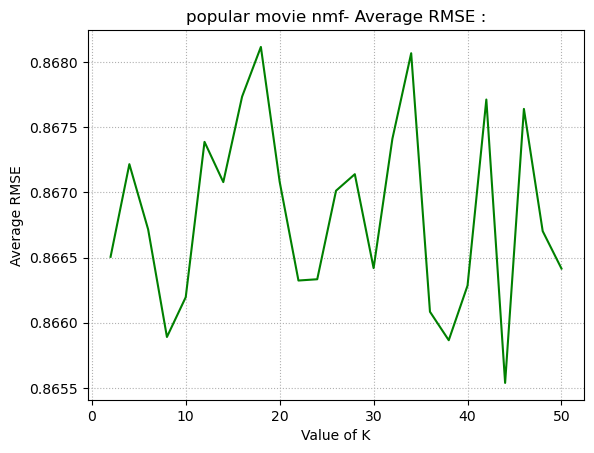

unpopular Optimal latent factor: 2
unpopular Min average RMSE 0.8828295775054436


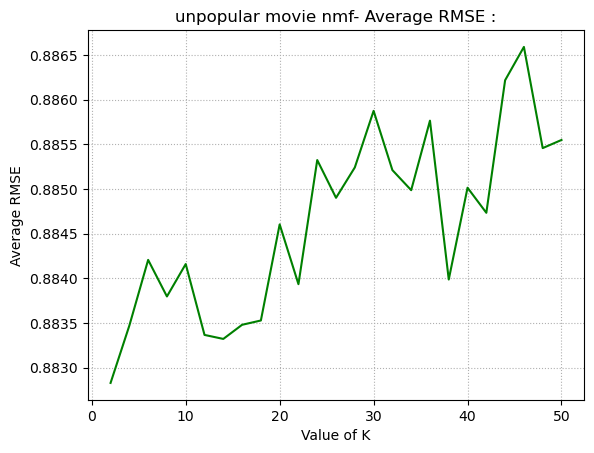

high variance Optimal latent factor: 32
high variance Min average RMSE 0.8958574149770048


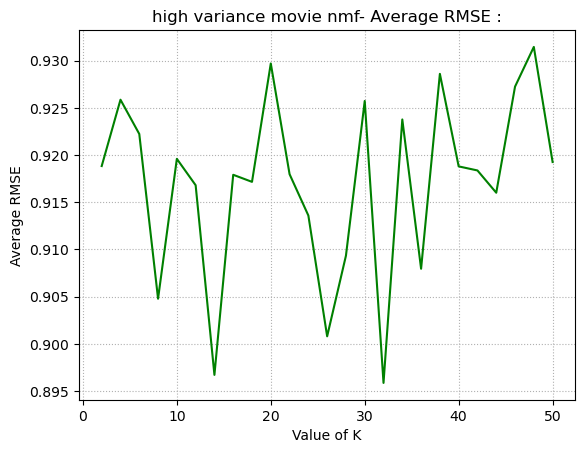

In [35]:
Ks = np.arange(2,52,2)
cv = 10
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)

for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)
    trimmed_rmse_svd = []

    for k in Ks:
        temp_rmse_svd = []
        svd = SVD(n_factors = k)
        for training, validation in kf.split(trimmed_dataset):
            res = svd.fit(trainset=training).test(validation)
            temp_rmse_svd.append(accuracy.rmse(res, verbose= False))
        trimmed_rmse_svd.append(np.mean(temp_rmse_svd))
    idx = np.argmin(trimmed_rmse_svd)
    optim_fac = Ks[idx]
    min_RMSE = min(trimmed_rmse_svd)
    print(name + " Optimal latent factor:", optim_fac )
    print(name + " Min average RMSE", min_RMSE)
    plot_k_rmse_for_mf(Ks, trimmed_rmse_svd, name)

<Figure size 640x480 with 0 Axes>

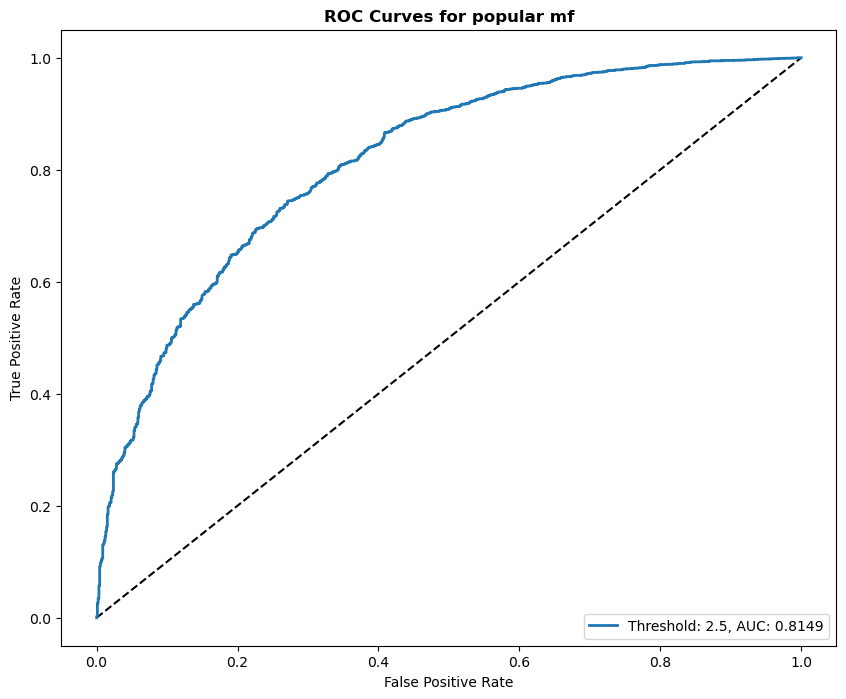

<Figure size 640x480 with 0 Axes>

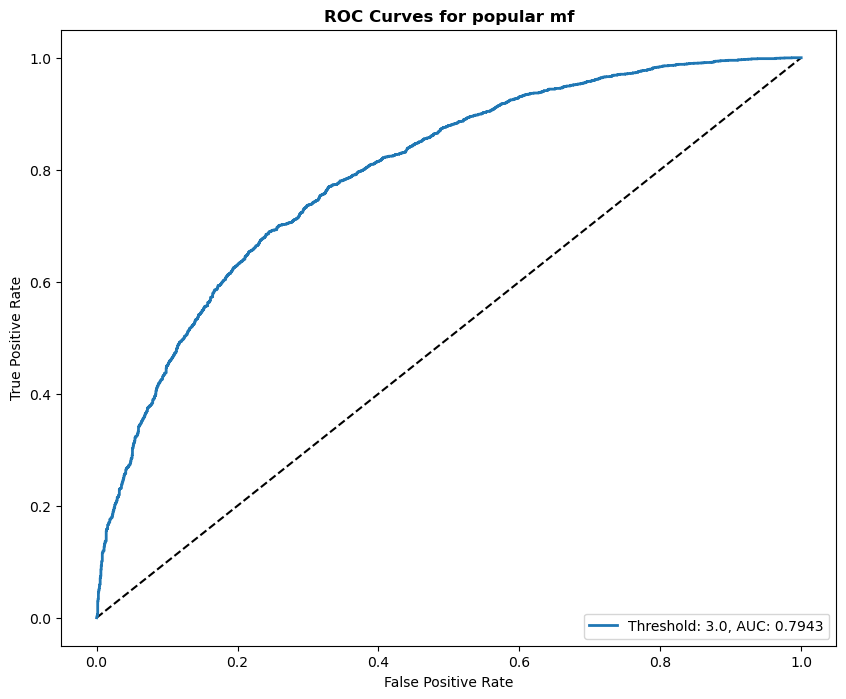

<Figure size 640x480 with 0 Axes>

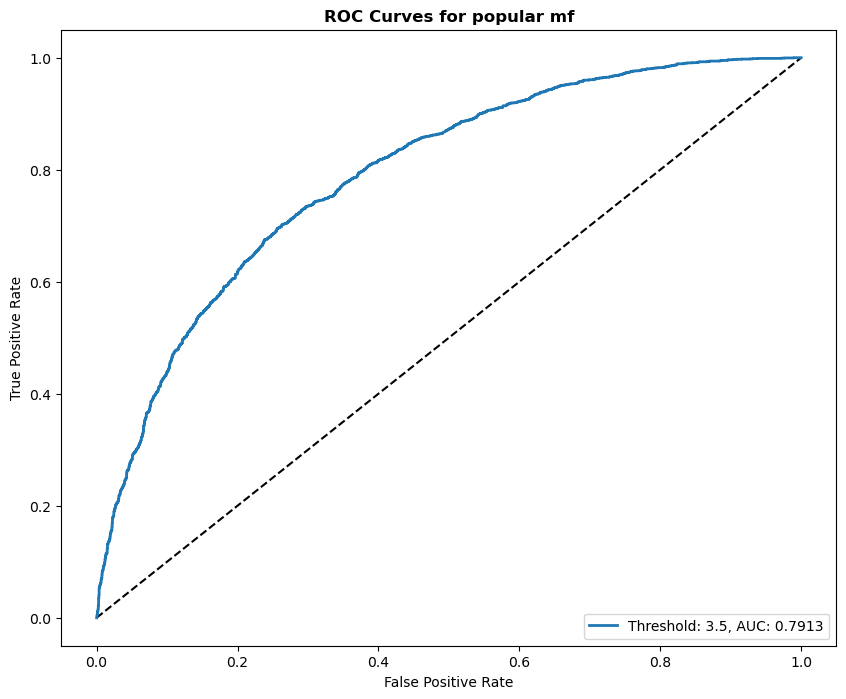

<Figure size 640x480 with 0 Axes>

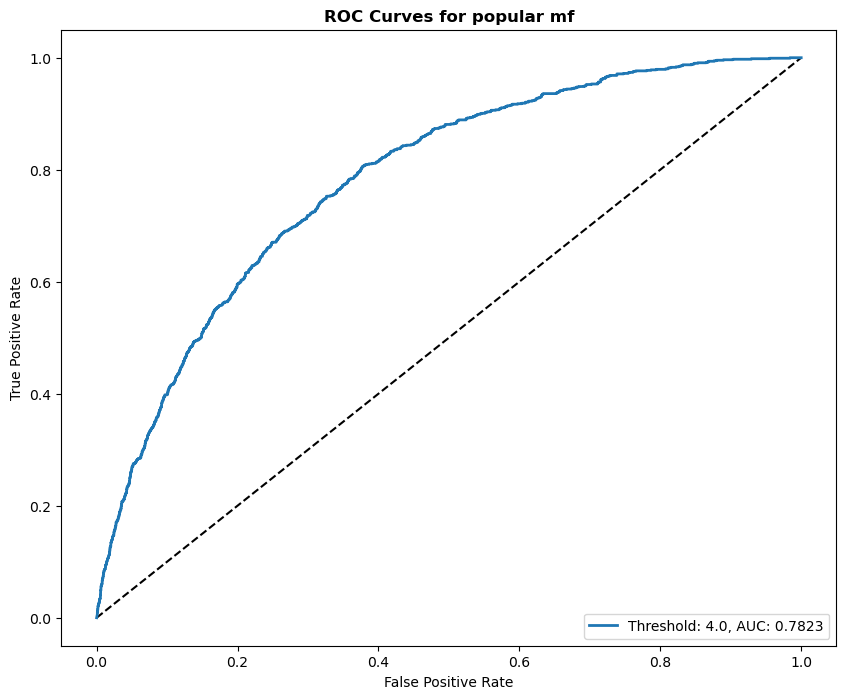

<Figure size 640x480 with 0 Axes>

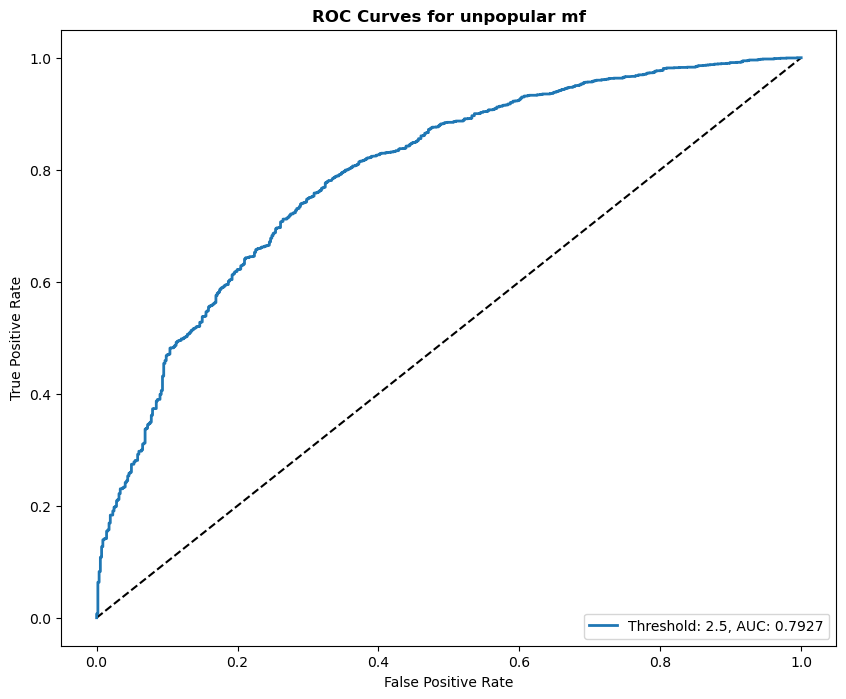

<Figure size 640x480 with 0 Axes>

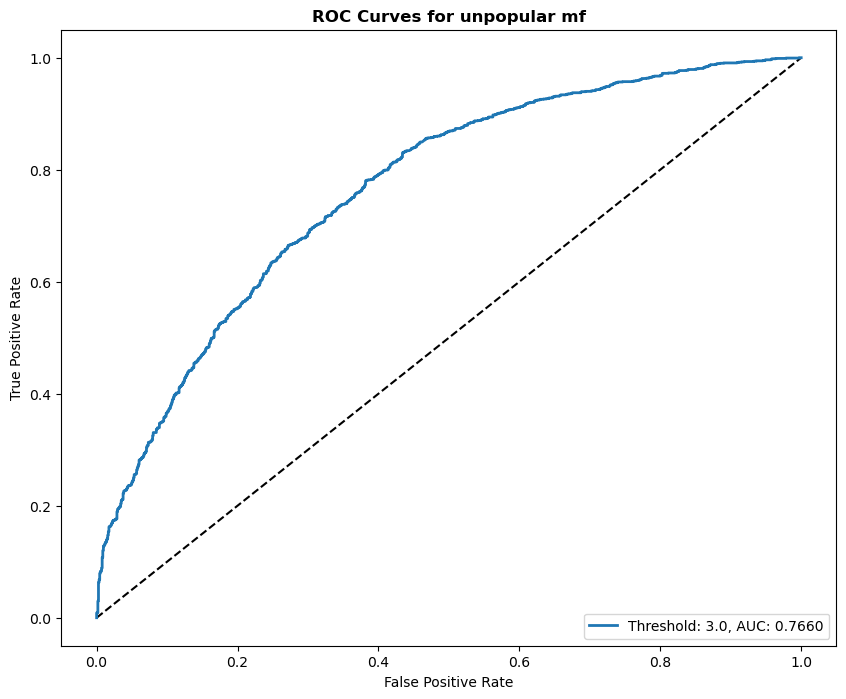

<Figure size 640x480 with 0 Axes>

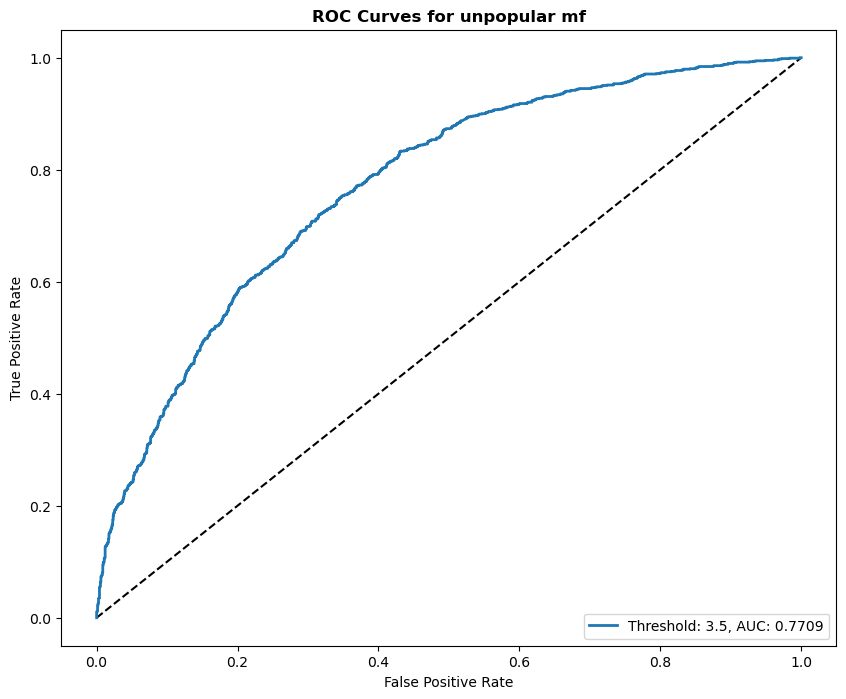

<Figure size 640x480 with 0 Axes>

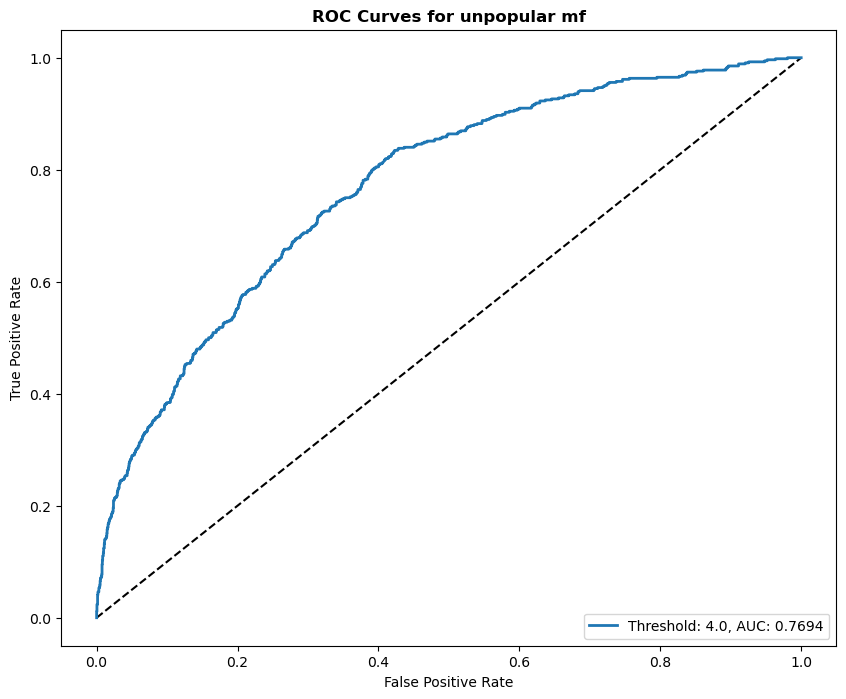

<Figure size 640x480 with 0 Axes>

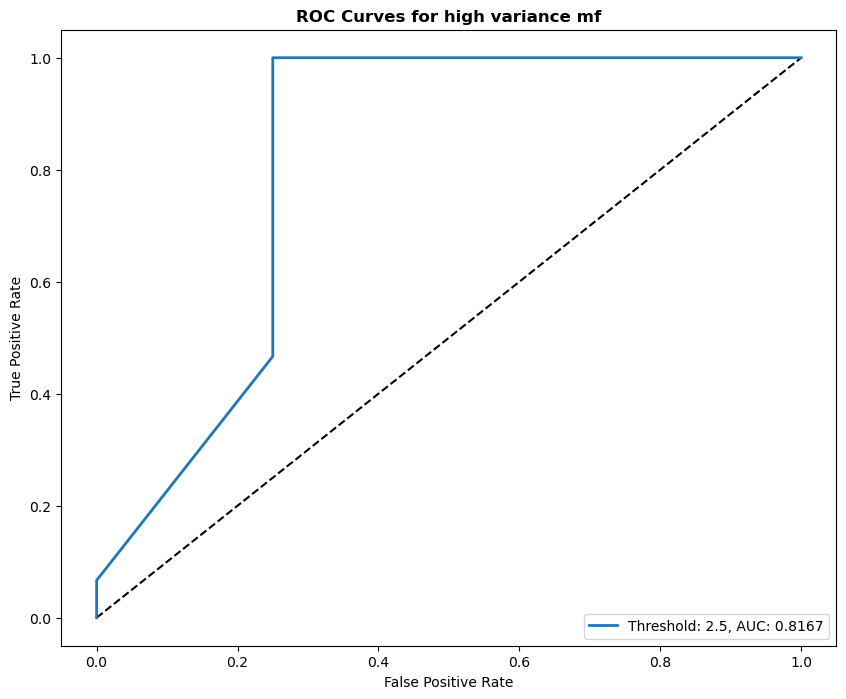

<Figure size 640x480 with 0 Axes>

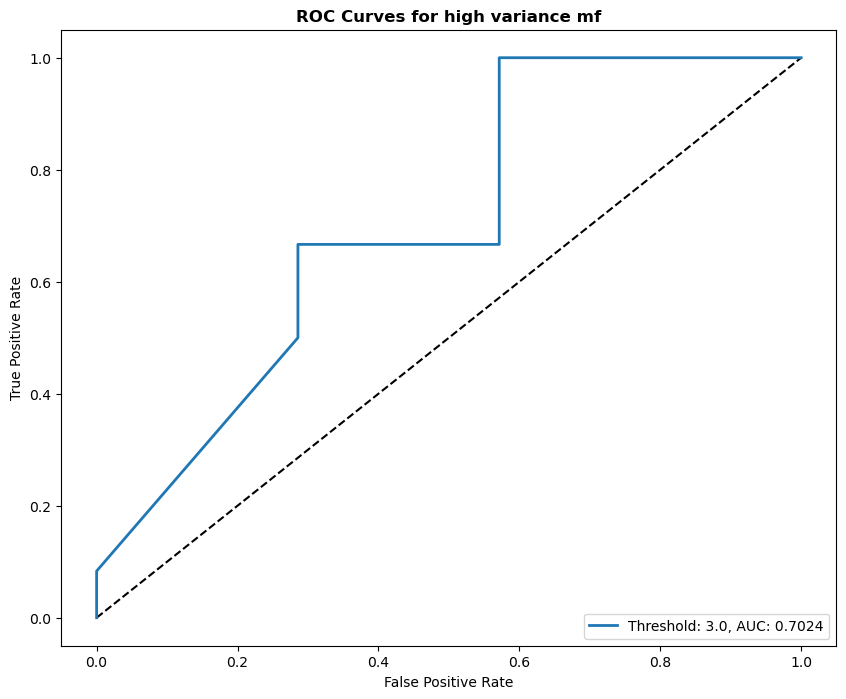

<Figure size 640x480 with 0 Axes>

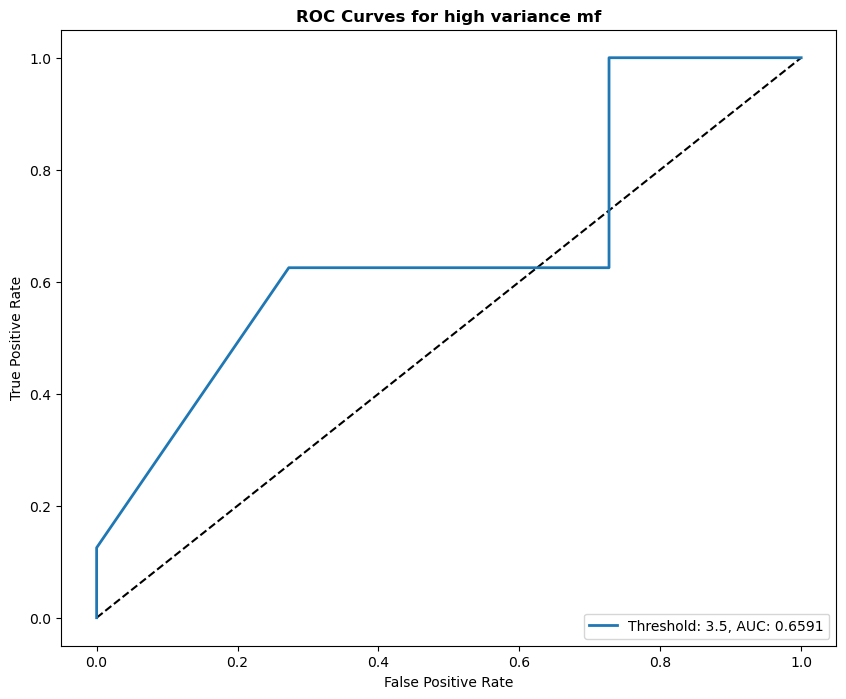

<Figure size 640x480 with 0 Axes>

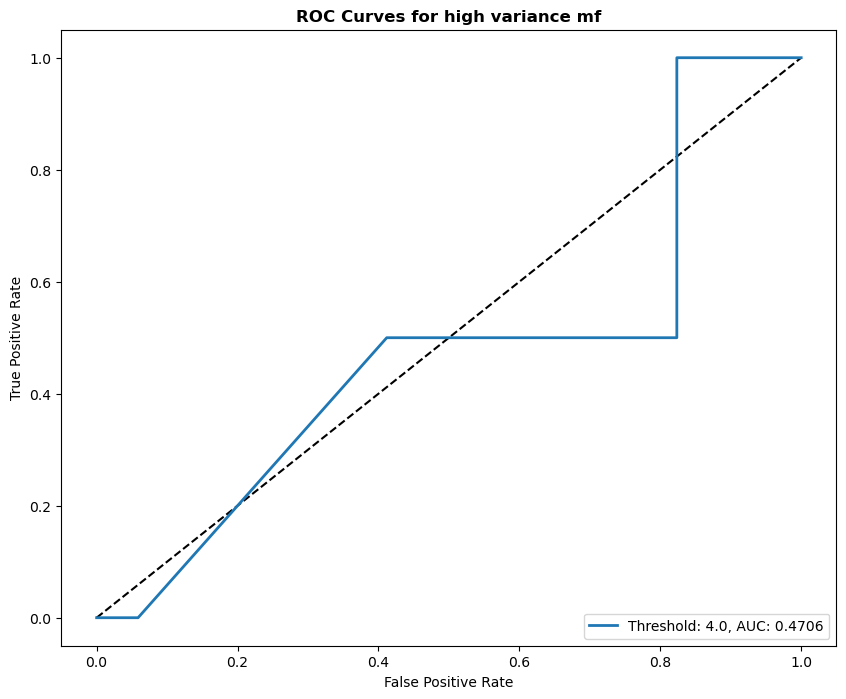

In [36]:
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 

opt_n = {'popular':44, 'unpopular':2, 'high variance':32}

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)
for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)

    k = opt_n[name]
    svd_opt = SVD(n_factors = k)
    training, validation = train_test_split(trimmed_dataset, test_size= 0.1)
            
    res = svd_opt.fit(trainset=training).test(validation)
    y_true = [val[2] for val in  validation]
    plot_threshold_roc_curve_mf(y_true, res, trimmed_name= name, K= k)

## Question11(A)

In [5]:
# get all ratings every user gives out
user_id_rating = {}
user_id_mean_rating = {}
for raw in Dataset_Ratings.raw_ratings:
    user_id = raw[0]
    rating = raw[2]
    if user_id not in user_id_rating.keys():
        user_id_rating[user_id] = []
    user_id_rating[user_id].append(rating)

# get every user's mean rating
for user_id in user_id_rating.keys():
    user_id_mean_rating[user_id] = np.mean(user_id_rating[user_id])

# split training and testing set
k_fold = KFold(n_splits=10)
rmse_naive_raw = []
for training, testing in k_fold.split(Dataset_Ratings):
    rmse_cv = 0
    num_testing = len(testing)
    for user in testing:
        y_pred_testing = user_id_mean_rating[user[0]]
        y_label_testing = user[2]
        err = np.square(y_pred_testing - y_label_testing)
        rmse_cv+=err
    rmse_cv = np.sqrt(rmse_cv / num_testing)
    rmse_naive_raw.append(rmse_cv)
rmse_naive = np.mean(rmse_naive_raw)
print('RMSE of naive filter on original dataset is', rmse_naive)

RMSE of naive filter on original dataset is 0.9346916454117264


## Question11(B)

In [8]:
Ks = np.arange(2,52,2)
cv = 10
trimmed_ratings_with_name = []
trimmed_ratings_with_name.append(('popular', trim_popular(ratings) ))
trimmed_ratings_with_name.append( ('unpopular', trim_unpopular(ratings) ))
trimmed_ratings_with_name.append( ('high variance',  trimm_high_var(ratings) )) 

reader = Reader(rating_scale=(0.5, 5))
kf = KFold(n_splits= 10)

for name, rating_ in trimmed_ratings_with_name:
    trimmed_dataset = Dataset.load_from_df(rating_[['userId', 'movieId', 'rating']], reader= reader)
    rmse_naive_raw  = []
    err = 0

    for training, testing in kf.split(trimmed_dataset):
        num_testing = len(testing)
        y_pred_testing = [user_id_mean_rating[user[0]] for user in testing]
        y_label_testing = [user[2] for user in testing]
        err = np.sqrt(mean_squared_error(y_pred_testing, y_label_testing))
        rmse_naive_raw.append(err)
    rmse_naive = np.mean(rmse_naive_raw)

    print("RMSE of naive filter on",name, 'sub dataset is', rmse_naive)

RMSE of naive filter on popular sub dataset is 0.9475737787008075
RMSE of naive filter on unpopular sub dataset is 0.9522995172773708
RMSE of naive filter on high variance sub dataset is 0.9441423322361592


## Question12

In [9]:
reader = Reader(rating_scale=(0.5, 5))
Dataset_Ratings = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']] ,reader=reader)
train_set, test_set = train_test_split(Dataset_Ratings, test_size=0.1)
knn_opt = KNNWithMeans(k=56, sim_options={'name':'pearson'}, verbose=False).fit(train_set).test(test_set)
nmf_opt = NMF(n_factors=16).fit(train_set).test(test_set)
svd_opt = SVD(n_factors=34).fit(train_set).test(test_set)
y_true = [test[2] for test in  test_set]

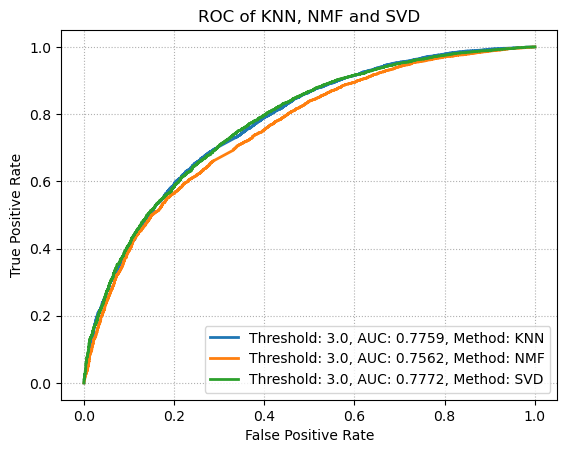

In [10]:
method = [knn_opt, nmf_opt, svd_opt]
method_name = ['KNN', 'NMF', 'SVD']
threshold = 3
for i in range(len(method)):
    name = method_name[i]
    binary_y_true = []
    for row in y_true:
        if row > threshold:
            binary_y_true.append(1)
        else:
            binary_y_true.append(0)
    y_pred = [row.est for row in method[i]]
    fpr, tpr, _ = roc_curve(binary_y_true, y_pred)
    auc_score = roc_auc_score(binary_y_true, y_pred)
    plt.plot(fpr, tpr, label = 'Threshold: %.1f, AUC: %.4f, Method: %s' %(threshold,auc_score,name), linewidth=2)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC of KNN, NMF and SVD')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig(os.path.join(fig_path,'Q12.png'),dpi=350,bbox_inches='tight')
plt.show()

## Question14


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


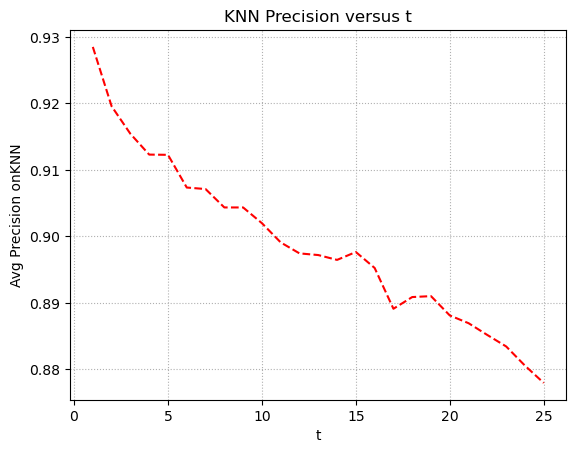

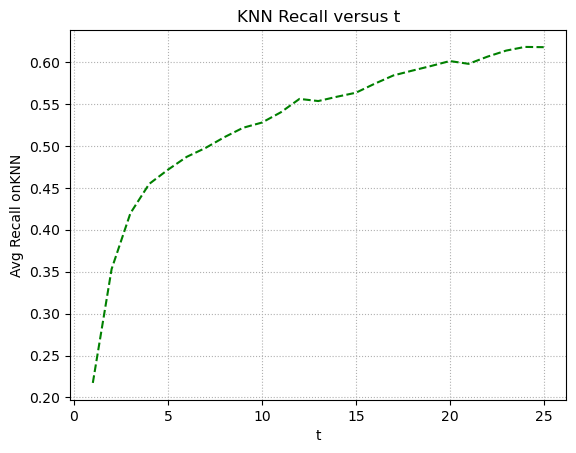

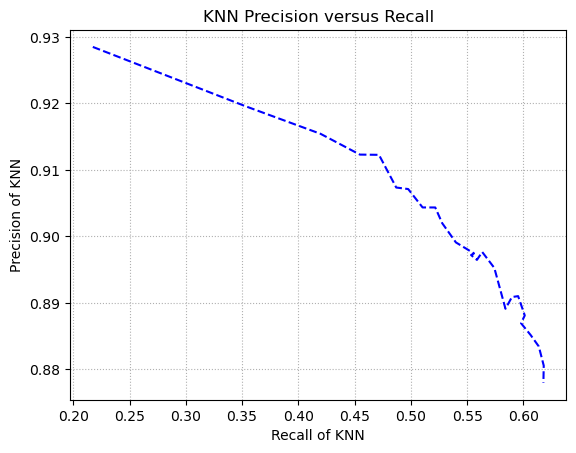


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


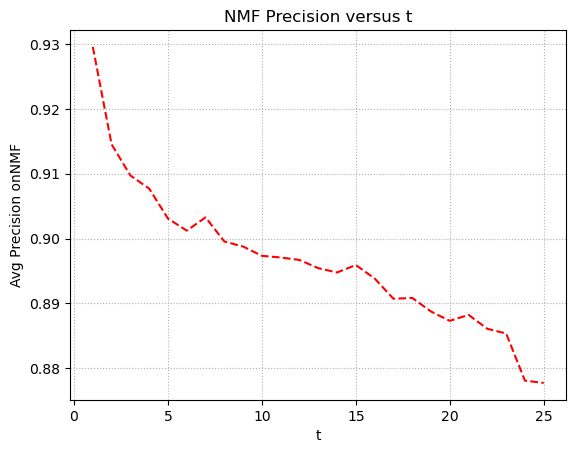

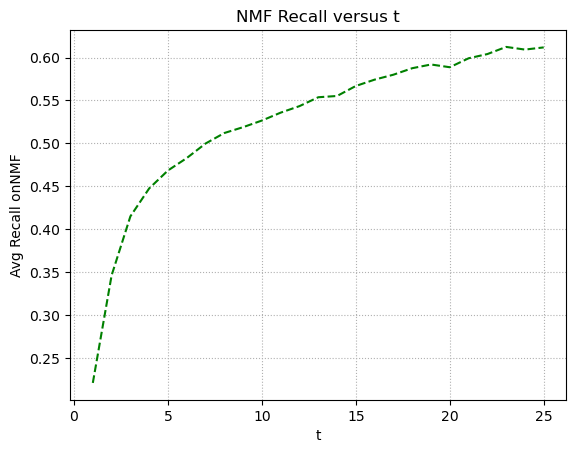

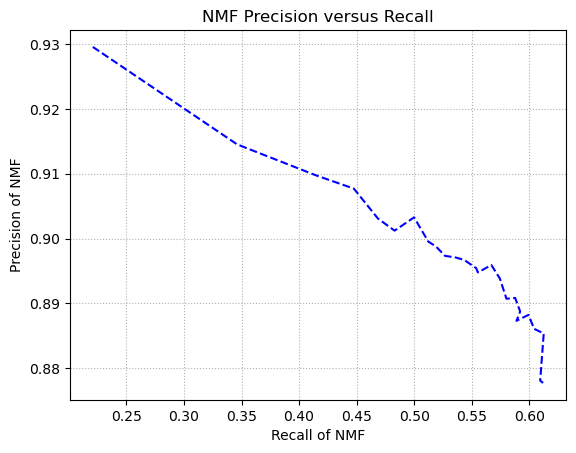


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


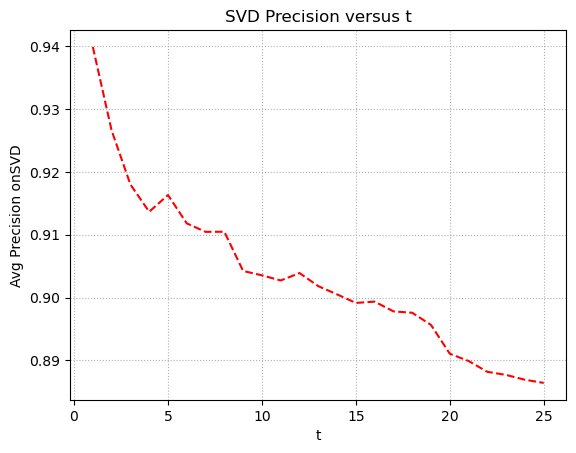

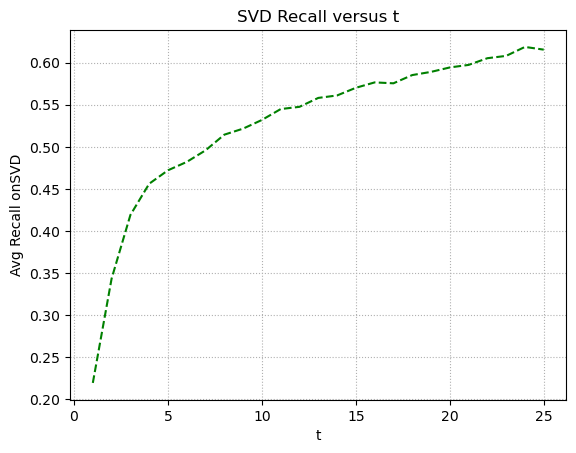

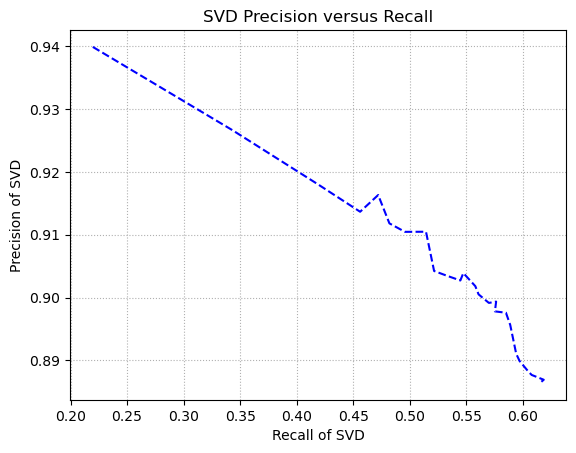

In [7]:
# G: The set of items liked by the user (ground-truth positives)
def get_G_list(dataset, threshold):
    G = {}
    for row in dataset:
        if row[0] not in G.keys():
            G[row[0]] = []
            if row[2] >= threshold:
                G[row[0]].append(row[1])
        else:
            if row[2] >= threshold:
                G[row[0]].append(row[1])
    return G

# R: The set of items rated by the user
def get_R_list(dataset):
    R = {}
    for row in dataset:
        if row[0] not in R.keys():
            R[row[0]] = []
            R[row[0]].append(row[1])
        else:
            R[row[0]].append(row[1])
    return R

# E: The set of items and ratings estimated by our data
def get_E_list(model_res):
    E = {}
    for row in model_res:
        uid, mid, rating = row[0], row[1], row[3]
        if uid not in E.keys():
            E[uid] = []
            E[uid].append((mid, rating))
        else:
            E[uid].append((mid,rating))
    return E


reader = Reader(rating_scale=(0.5, 5))
Dataset_Ratings = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']] ,reader=reader)
knn_pr = KNNWithMeans(k =36, sim_options={'name':'pearson'}, verbose=False)
nmf_pr = NMF(n_factors=16)
svd_pr = SVD(n_factors=34)

k_fold = KFold(n_splits=10)
models = [knn_pr, nmf_pr, svd_pr]
model_names = ['KNN', 'NMF', 'SVD']
Ts = np.arange(1,26,1)
threshold = 3


for i in range(len(models)):
    model = models[i]
    name = model_names[i]
    precision_t = []
    recall_t = []
    print( )
    for t in Ts:
        print(t)
        precision = []
        recall = []
        for train, test in k_fold.split(Dataset_Ratings):
            G = get_G_list(test, threshold)
            R = get_R_list(test)
            test_drop = [row for row in test if (len(R[row[0]]) >= t and len(G[row[0]]) > 0)]
            res = model.fit(train).test(test_drop)
            E = get_E_list(res)

            precision_temp = 0
            recall_temp = 0
            num = len(E)
            for row in E.keys():
                all_recommened = E[row]
                all_recommened_sorted = sorted(all_recommened,key=lambda x:x[1])[::-1]
                top_t = set([row[0] for row in all_recommened_sorted[0:t]])
                precision_temp += len(top_t.intersection(G[row]))/len(top_t)
                recall_temp += len(top_t.intersection(G[row]))/len(G[row])
            precision.append(precision_temp / num)
            recall.append(recall_temp / num)

        precision_t.append(np.mean(precision))
        recall_t.append(np.mean(recall))

    plt.plot(Ts,precision_t,linestyle='--',color='red')
    plt.grid(linestyle=':')
    plt.title(name + ' Precision versus t')
    plt.ylabel('Avg Precision on' + name)
    plt.xlabel('t')
    plt.savefig(os.path.join(fig_path, 'Q14_precision_' + name + '.png'), dpi=350,bbox_inches='tight')
    plt.show()

    plt.plot(Ts,recall_t,linestyle='--',color='green')
    plt.grid(linestyle=':')
    plt.title(name + ' Recall versus t')
    plt.ylabel('Avg Recall on' + name)
    plt.xlabel('t')
    plt.savefig(os.path.join(fig_path, 'Q14_recall_' + name + '.png'), dpi=350,bbox_inches='tight')
    plt.show()

    plt.plot(recall_t, precision_t,linestyle='--',color='blue')
    plt.grid(linestyle=':')
    plt.title(name + ' Precision versus Recall')
    plt.ylabel('Precision of ' + name)
    plt.xlabel('Recall of ' + name)
    plt.savefig(os.path.join(fig_path, 'Q14_precision_vs_recall_' + name + '.png'), dpi=350,bbox_inches='tight')
    plt.show()